# 0. IMPORTS

## 0.1 IMPORT LIBRARIES

In [1]:
import datetime
import calendar
import math
import inflection
import warnings
import random
import pickle
import joblib

import pandas            as pd
import numpy             as np
import seaborn           as sns
import researchpy        as rp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost           as xgb

from matplotlib.gridspec     import GridSpec
from IPython.display         import Image
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.metrics         import mean_absolute_error,  mean_absolute_percentage_error,  mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from boruta                  import BorutaPy

## 0.2 SET PARAMETERS

In [2]:
# set figure features 
plt.rcParams['figure.figsize'] = (20, 8)

# set seaborn theme
sns.set_theme(context='notebook', palette='pastel')

# ignore alerts
warnings.filterwarnings('ignore')

# set number format
formatter = ticker.StrMethodFormatter('{x:,.0f}')

## 0.3 LOAD DATA

In [3]:
# load dataset
df_sales = pd.read_csv('data/train.csv', low_memory=False)

# load some store info
df_store = pd.read_csv('data/store.csv', low_memory=False)

# merge dataframes
df_raw = pd.merge(df_sales, df_store, how='left', on='Store')

# selecting the first 300 stores, due to a load issue
df_raw = df_raw.loc[df_raw['Store'] <= 300, :].reset_index(drop=True)
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. FUNCTIONS

In [145]:
# data clean
def data_clean(df):

    df_copy = df.copy()
    
    # rename columns
    cols = df_copy.columns.to_list()
    cols_updated = list(map(inflection.underscore, cols))
    df_copy.columns = cols_updated

    # change data types 
    df_copy['date'] = pd.to_datetime(df_copy['date'])
        
    # fill na's
    # competition distance
    df_copy['competition_distance'] = df_copy['competition_distance'].apply(lambda x: 58260 if pd.isnull(x) else x)
    
    # competition open since month 
    max_date = df_copy['date'].max()
    df_copy['competition_open_since_month'] = df_copy['competition_open_since_month'].apply(lambda x: max_date.strftime('%m') if pd.isnull(x) else x)
    df_copy['competition_open_since_month'] = df_copy['competition_open_since_month'].astype('int64')
        
    # competition open since year
    df_copy['competition_open_since_year'] = df_copy['competition_open_since_year'].apply(lambda x: max_date.strftime('%Y') if pd.isnull(x) else x)
    df_copy['competition_open_since_year'] = df_copy['competition_open_since_year'].astype('int64')
    
    # promo2 since week
    df_copy['promo2_since_week'] = df_copy['promo2_since_week'].apply(lambda x: max_date.strftime('%W') if pd.isnull(x) else x)
    df_copy['promo2_since_week'] = df_copy['promo2_since_week'].astype('int64')
    
    # promo2 since year
    df_copy['promo2_since_year'] = df_copy['promo2_since_year'].apply(lambda x: max_date.strftime('%Y') if pd.isnull(x) else x)
    df_copy['promo2_since_year'] = df_copy['promo2_since_year'].astype('int64')
    
    # promointerval
    df_copy.drop('promo_interval', axis=1, inplace=True)

    return df_copy

# create cramer's 
def cramers_v(data, x, y):
    '''
    Function that calculates the correlation between 2 categorical features
    data: Dataset that contains the data
    x: Feature 1
    y: Feature 2
    Returns: Cramer's V coefficient
    '''
    
    return rp.crosstab(data[x], data[y], prop='col', test='chi-square')[1]['results'][2]

# 2. DATA DESCRIPTION

In [5]:
# make a copy of raw dataframe
df2 = df_raw.copy()

## 2.1 DATA DIMENSIONS

In [6]:
print(f'The dataset have {df2.shape[0]} rows and {df2.shape[1]} columns')

The dataset have 272480 rows and 18 columns


## 2.2 DATA TYPES

In [7]:
df2.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

## 2.3 CHECKING NA's

In [8]:
df2.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance             942
CompetitionOpenSinceMonth     85626
CompetitionOpenSinceYear      85626
Promo2                            0
Promo2SinceWeek              138886
Promo2SinceYear              138886
PromoInterval                138886
dtype: int64

## 2.4 DATA CLEANING AND TREATMENT

- Competition distance: The stategy for competition distance is to set the maximum value for all null values.
- Competition since month: We will consider that null values means that there's no competition. So, we will add the month of the last date of the dataframe.
- Competition since month: Same estrategy as for competition since month.
- Promo2 since week: Same strategy as above. Will add the last week on the dataset, but instead of putting the week number, we will put the month number.
- Promo2 since year: The same strategy, but adding the year.
- Promo Interval: It seems that, when promo interval is filled, the column promo2 is also filled with a 1. Since it looks like promo2 is a flag for when this field is filled, it seems that this field doesn't carry useful information.

In [9]:
# apply data clening 
df2 = data_clean(df2)
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
dtype: int64

## 2.5 DESCRIPTIVE STATISTICS

In [10]:
# separate categorical and numerical fatures
cat_att = df2.select_dtypes(include=['object'])
num_att = df2.select_dtypes(exclude=['object', 'datetime64[ns]'])

### 2.5.1 NUMERICAL ATTRIBUTES

In [11]:
# mean, median, min, max, quartiles, std
described_num = num_att.describe().T.drop('count', axis=1)

# range
described_num['range'] = described_num['max'] - described_num['min']

# skew and kurtosis
#skew = pd.DataFrame(num_att.T.apply(lambda x: x.skew(), axis=1), columns=['skew'])
#kurtosis = pd.DataFrame(num_att.T.apply(lambda x: x.kurtosis(), axis=1), columns=['kurtosis'])
skew = pd.DataFrame(num_att.apply(lambda x: x.skew(), axis=0), columns=['skew'])
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis(), axis=0), columns=['kurtosis'])

# merge data
num_metrics = pd.concat([described_num, skew, kurtosis], axis=1).reset_index()

# rename columns
num_metrics.rename(columns={'index':'feature', '50%': 'median'}, inplace=True)

# rearrange columns
num_metrics = num_metrics[['feature', 'mean', 'median', 'std', '25%', 'median', '75%', 'min', 'max', 'range', 'skew', 'kurtosis']]
num_metrics

,feature,mean,median,std,25%,median,75%,min,max,range,skew,kurtosis
0,store,150.365282,151.0,86.783931,75.0,151.0,226.0,1.0,300.0,299.0,-0.002514,-1.208142
1,day_of_week,3.998404,4.0,1.997400,2.0,4.0,6.0,1.0,7.0,6.0,0.001520,-1.246866
2,sales,5651.874769,5736.0,3683.476771,3758.0,5736.0,7690.0,0.0,38722.0,38722.0,0.618874,2.404509
3,customers,605.296308,600.0,425.127101,408.0,600.0,807.0,0.0,5494.0,5494.0,1.656806,9.787661
4,open,0.829554,1.0,0.376024,1.0,1.0,1.0,0.0,1.0,1.0,-1.752848,1.072485
5,promo,0.381422,0.0,0.485737,0.0,0.0,1.0,0.0,1.0,1.0,0.488241,-1.761633
6,school_holiday,0.178193,0.0,0.382676,0.0,0.0,0.0,0.0,1.0,1.0,1.681891,0.828764
7,competition_distance,5630.866706,2370.0,8291.964184,900.0,2370.0,6880.0,40.0,58260.0,58220.0,3.099766,13.003025
8,competition_open_since_month,7.248914,7.0,2.730967,6.0,7.0,9.0,1.0,12.0,11.0,-0.091557,-0.577567
9,competition_open_since_year,2010.787522,2013.0,5.329302,2008.0,2013.0,2015.0,1961.0,2015.0,54.0,-3.313612,24.770194


### 2.5.2 CATEGORICAL ATTRIBUTES

In [12]:
# Show the number of categories
cat_att.apply(lambda x: x.unique().shape[0])

state_holiday    4
store_type       4
assortment       3
dtype: int64

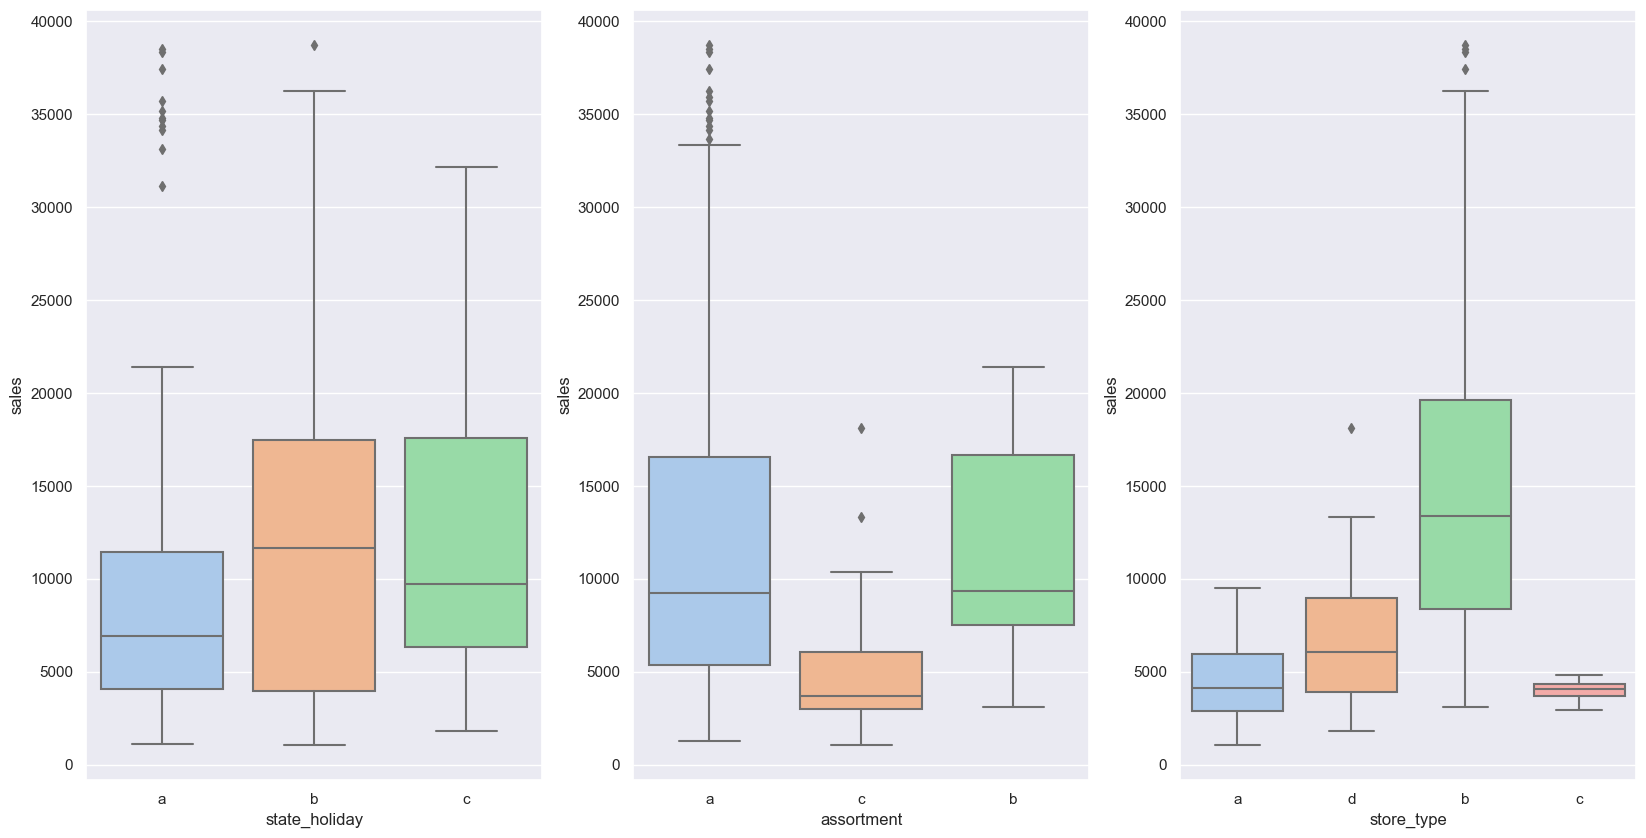

In [13]:
# create figure and axes
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

# filters
aux1 = df2.loc[((df2['sales'] > 0) & (df2['state_holiday'] != '0')), :]

# sales vs state holiday
sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=ax[0])

# sales vs assortment
sns.boxplot(x='assortment', y='sales', data=aux1, ax=ax[1])

# sales vs store type
sns.boxplot(x='store_type', y='sales', data=aux1, ax=ax[2])

plt.show()

# 3. FEATURE ENGINEERING

In [103]:
df3 = df2.copy()

## 3.1 HYPOTHESIS MAP

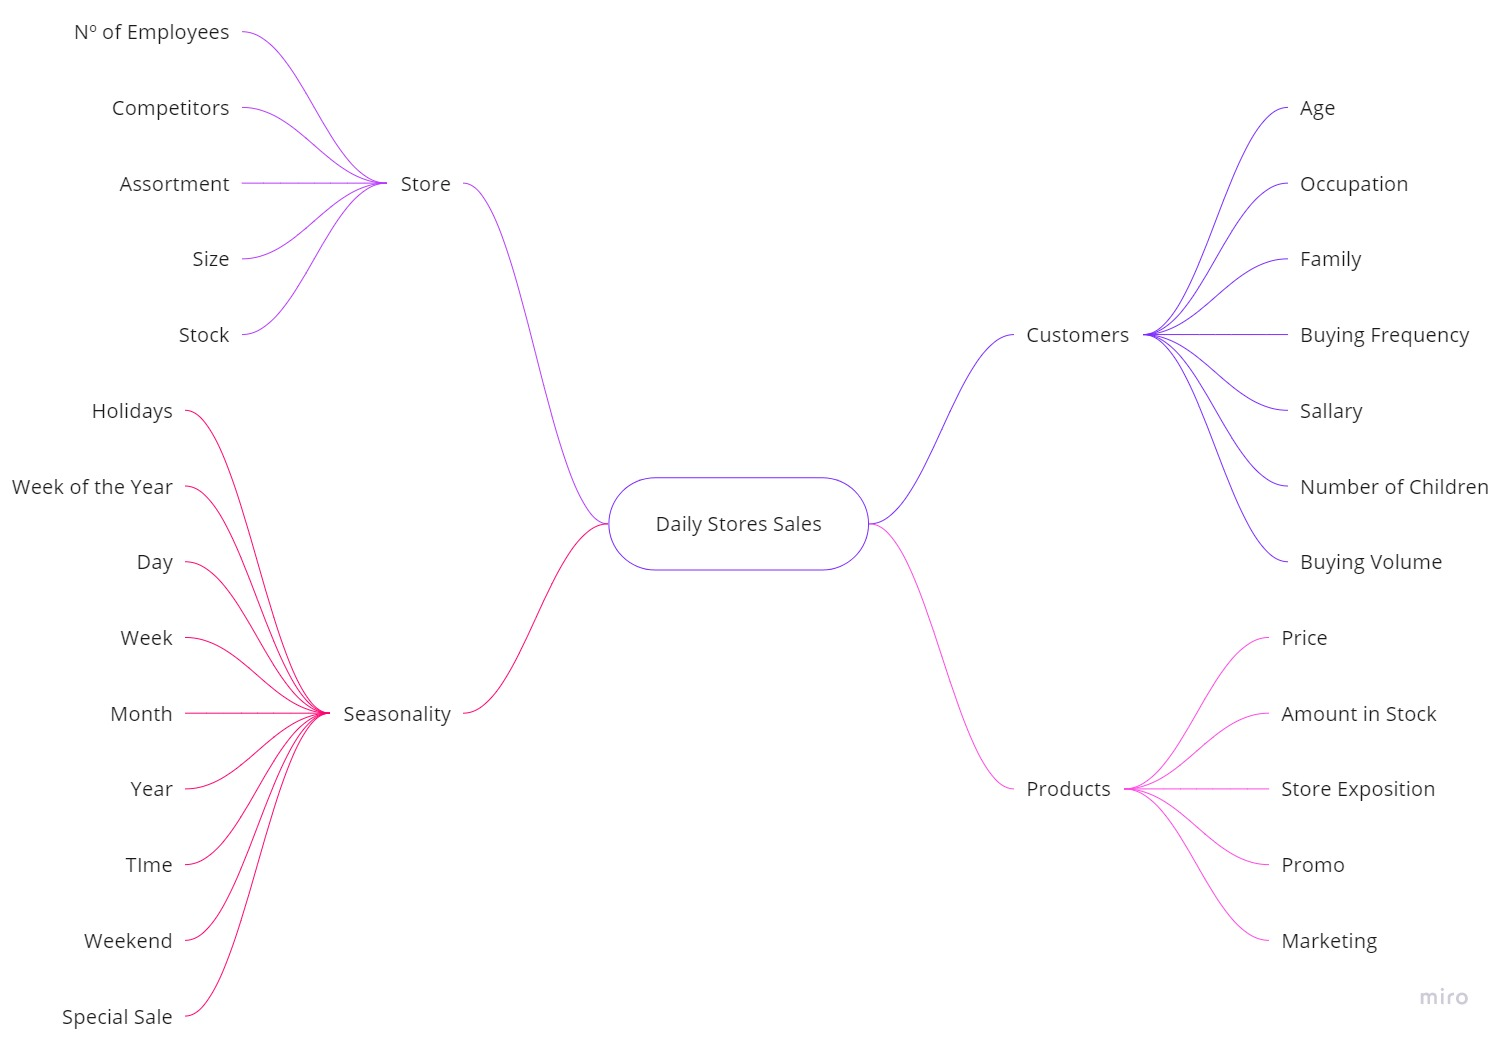

In [104]:
Image('img/mindmap.jpg')

## 3.2 CREATING HYPOTHESIS

### 3.2.1 STORES

1. Stores with more employees should sell more.
2. Stores with more stock capacity should sell more.
3. Larger stores should sell more.
4. Stores with a larger assortment should sell more.
5. Stores with closer competitors should sell less.
6. Stores with longer-term competitors should sell more.
7. Stores with more stock capacity should sell more.

### 3.2.2 PRODUCTS

1. Stores that invest more in marketing should sell more.
2. Stores with more product exposure should sell more.
3. Stores with lower priced products should sell more.
4. Stores with more aggressive promotions (larger discounts) should sell more.
5. Stores with longer promotions should sell more.
6. Stores with more promotion days should sell more.
7. Stores with more consecutive promotions should sell more.

### 3.2.3 SEASONALITY

1. Stores open during the Christmas holiday should sell more.
2. Stores should sell more over the years.
3. Stores should sell more in the second half of the year.
4. Stores should sell more after the 10th of each month.
5. Stores should sell less on weekends.
6. Stores should sell less during school holidays days.

## 3.3 PRIORITIZED LIST

1. Stores with a larger assortment should sell more.
2. Stores with closer competitors should sell less.
3. Stores with longer-term competitors should sell more.
4. Stores with longer promotions should sell more.
5. Stores with more promotion days should sell more.
6. Stores with more consecutive promotions should sell more.
7. Stores open during the Christmas holiday should sell more.
8. Stores should sell more over the years.
9. Stores should sell more in the second half of the year.
10. Stores should sell more after the 10th day of each month.
11. Stores should sell less on weekends.
12. Stores should sell less during school holidays.

## 3.4 FEATURE ENGINEERING

In [105]:
# year
df3['year'] = df2['date'].dt.year

# month
df3['month'] = df2['date'].dt.month

# day of month
df3['day'] = df2['date'].dt.day

# week of year
df3['week_of_year'] = df2['date'].dt.isocalendar().week
df3['week_of_year'] = df3['week_of_year'].apply(lambda x: int(x))

# week of month
df3['week_of_month'] = df3.apply(lambda x: [i+1 for i in range(0, len(calendar.monthcalendar(x['year'], x['month']))) 
                                            if x['day'] in calendar.monthcalendar(x['year'], x['month'])[i]][0], axis=1)

# week + year
df3['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since date
df3['competition_since_date'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                      month=x['competition_open_since_month'], 
                                                                      day=1), axis=1)

# competition time (months)
df3['competition_time_months'] = (((df3['date'] - df3['competition_since_date']).dt.days)/30).astype(int)

# competition time (weeks)
df3['competition_time_weeks'] = (((df3['date'] - df3['competition_since_date']).dt.days)/7).astype(int)
 
# promo2 since
df3['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df3['promo2_since'] = df3['promo2_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# promo2 time (months)
df3['promo2_time_months'] = (((df3['date'] - df3['promo2_since']).dt.days)/30).astype(int)

# promo2 time (weeks)
df3['promo2_time_weeks'] = (((df3['date'] - df3['promo2_since']).dt.days)/7).astype(int)

# assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x== 'b' else 'extended')

# state holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter_holiday' if x == 'b' else 
                                                            'christmas' if x == 'c' else 
                                                            'no_holiday')

# 4. FEATURE FILTERING

In [106]:
df4 = df3.copy()

## 4.1 ROWS

In [107]:
# number of rows before filter
df4.shape[0]

272480

In [108]:
# filter rows that have opened stores and at least 1 sale
condition = (df4['open'] != 0) & (df4['sales'] > 0)

# apply the filter
df4 = df4.loc[condition, :].reset_index(drop=True)

# number of rows after filter
df4.shape[0]

226025

## 4.2 COLUMNS

In [109]:
# will drop customers and open column
cols = ['customers', 'open']
df4.drop(columns=cols, axis=1, inplace=True)

# 5. EXPLORATORY DATA ANALYSIS (EDA)

In [110]:
df5 = df4.copy()

## 4.1 UNIVARIATE ANALYSIS

In [111]:
# sales mean
np.mean(df5['sales'])

6813.506634221878

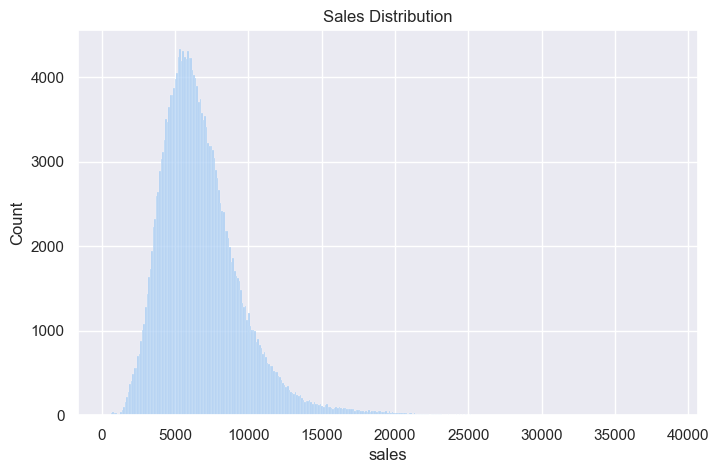

In [112]:
# plot sales distribution
fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(df4['sales'], legend=True, ax=ax)
ax.set_title('Sales Distribution')

plt.show()

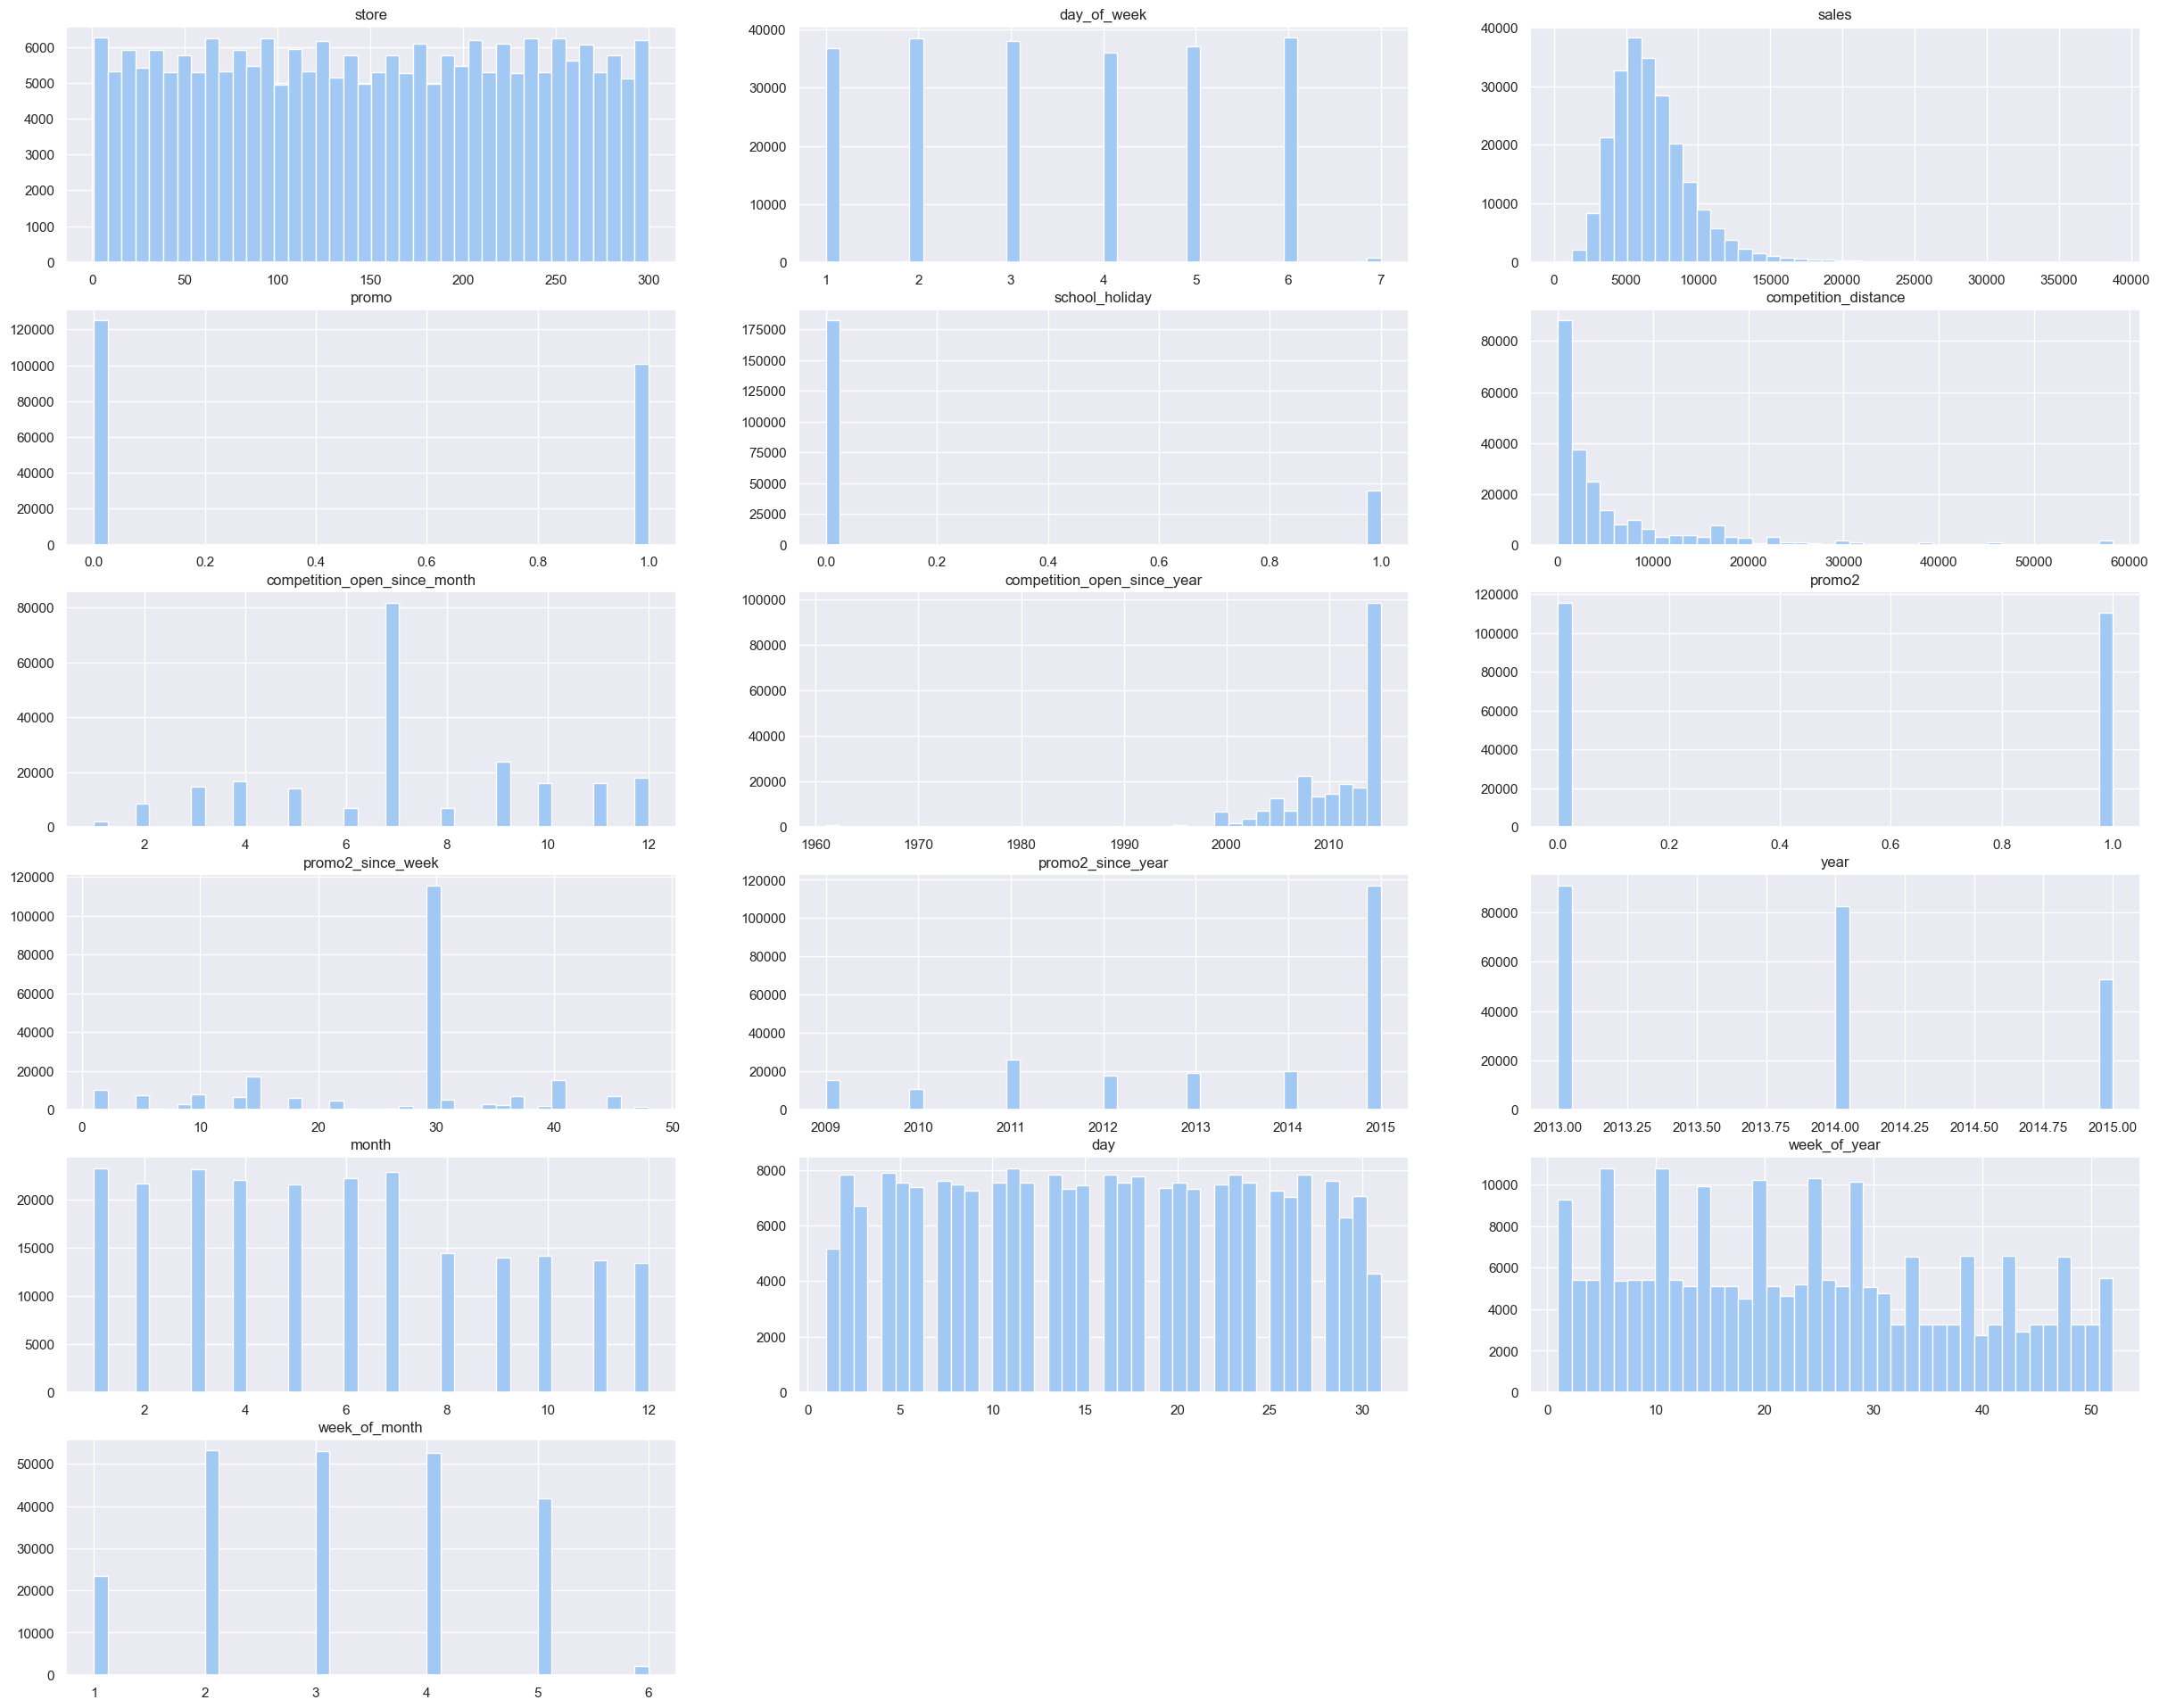

In [113]:
# plot numerical attributes
num_att = df4.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(30,24))

cols = num_att.columns.to_list()

for i in range(0, len(cols)):
    ax = plt.subplot(6, 3, i+1)
    ax.set_title(cols[i])
    num_att[cols[i]].hist(bins=40)

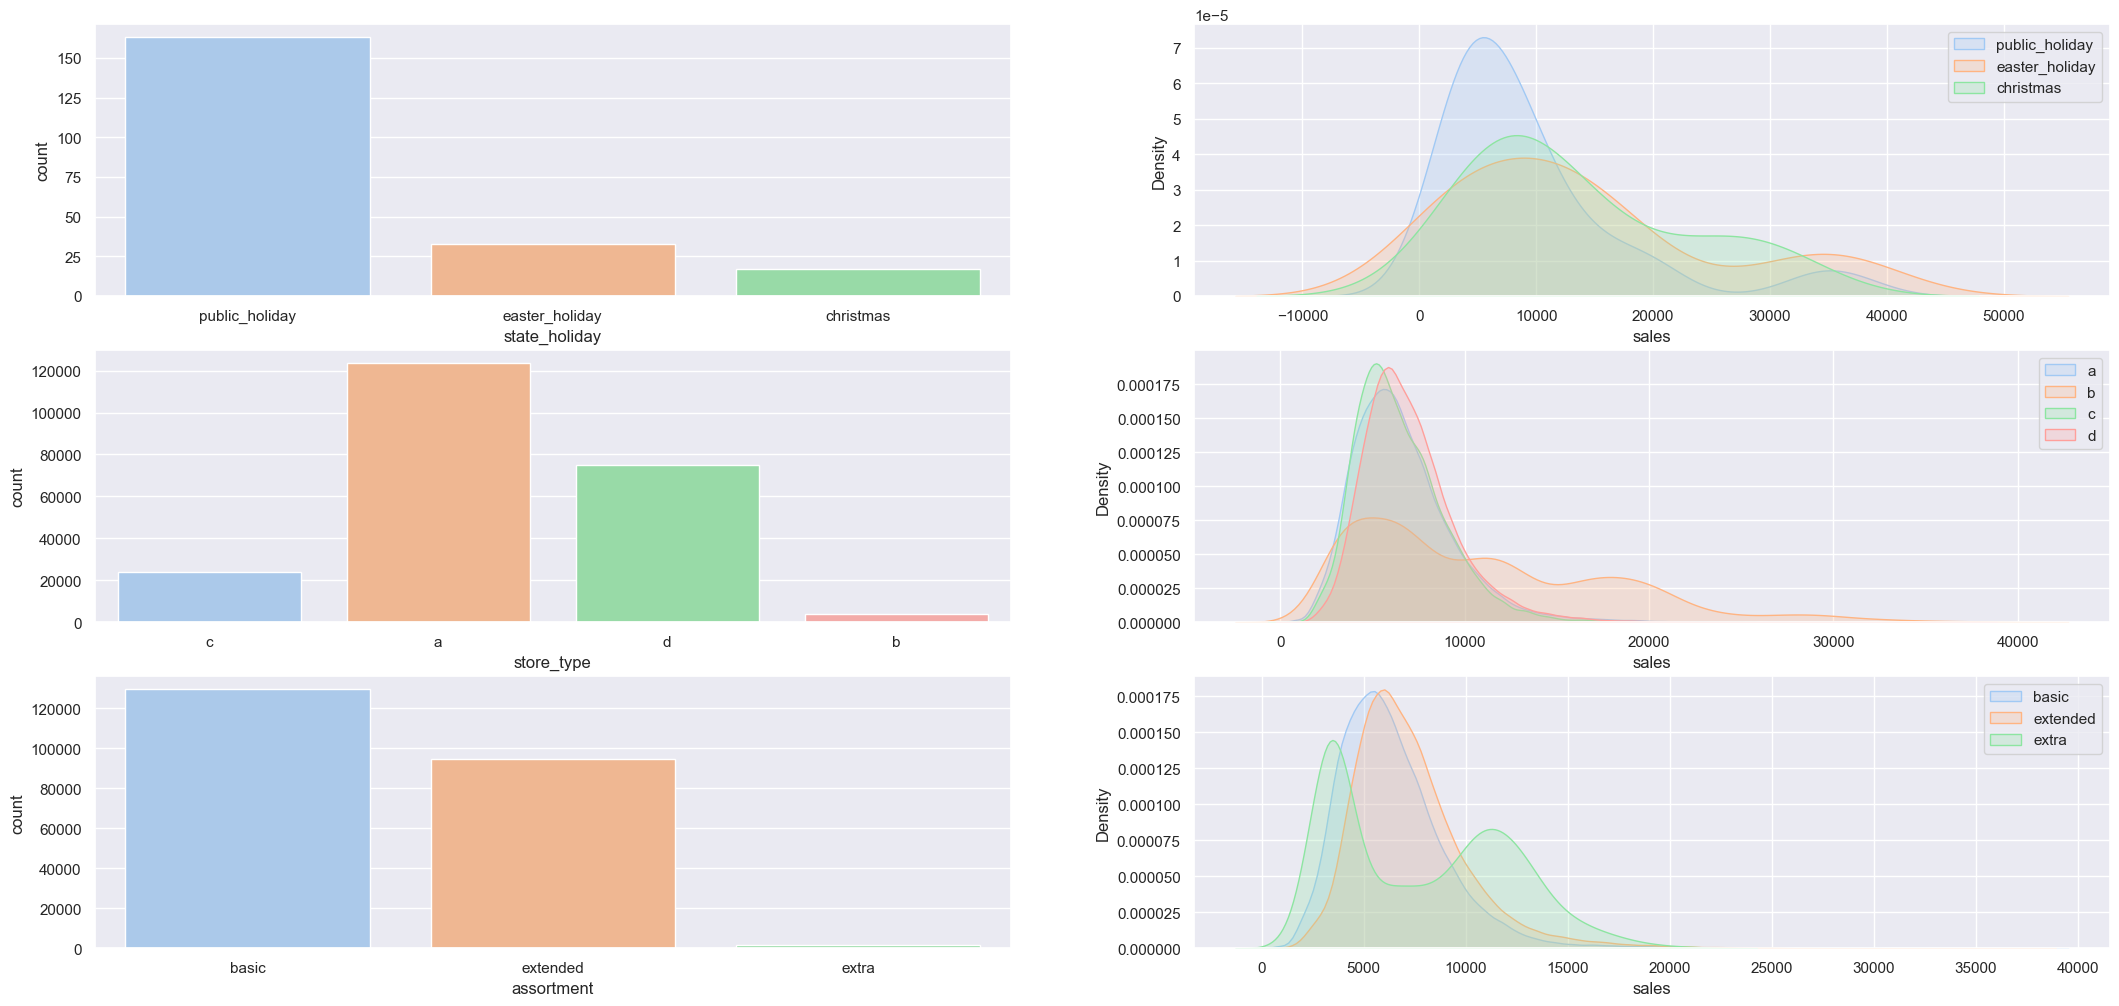

In [114]:
# Plot categorical attibutes vs sales
plt.figure(figsize=(26, 12))

# State holiday
a = df4[df4['state_holiday'] != 'no_holiday']

plt.subplot(3, 2, 1)
sns.countplot(x=a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend(labels=['public_holiday', 'easter_holiday', 'christmas'])

# Store type
plt.subplot(3, 2, 3)
sns.countplot(x= df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend(labels=['a', 'b', 'c', 'd'])

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(x= df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.legend(labels=['basic', 'extended', 'extra']);

## 4.2 BIVARIATE ANALYSIS

## H1 - Stores with a larger assortment should sell more
(FALSE) - Basic and extended assortment represent as bigger amount of sales. Throughout time, the behavior kept very stable

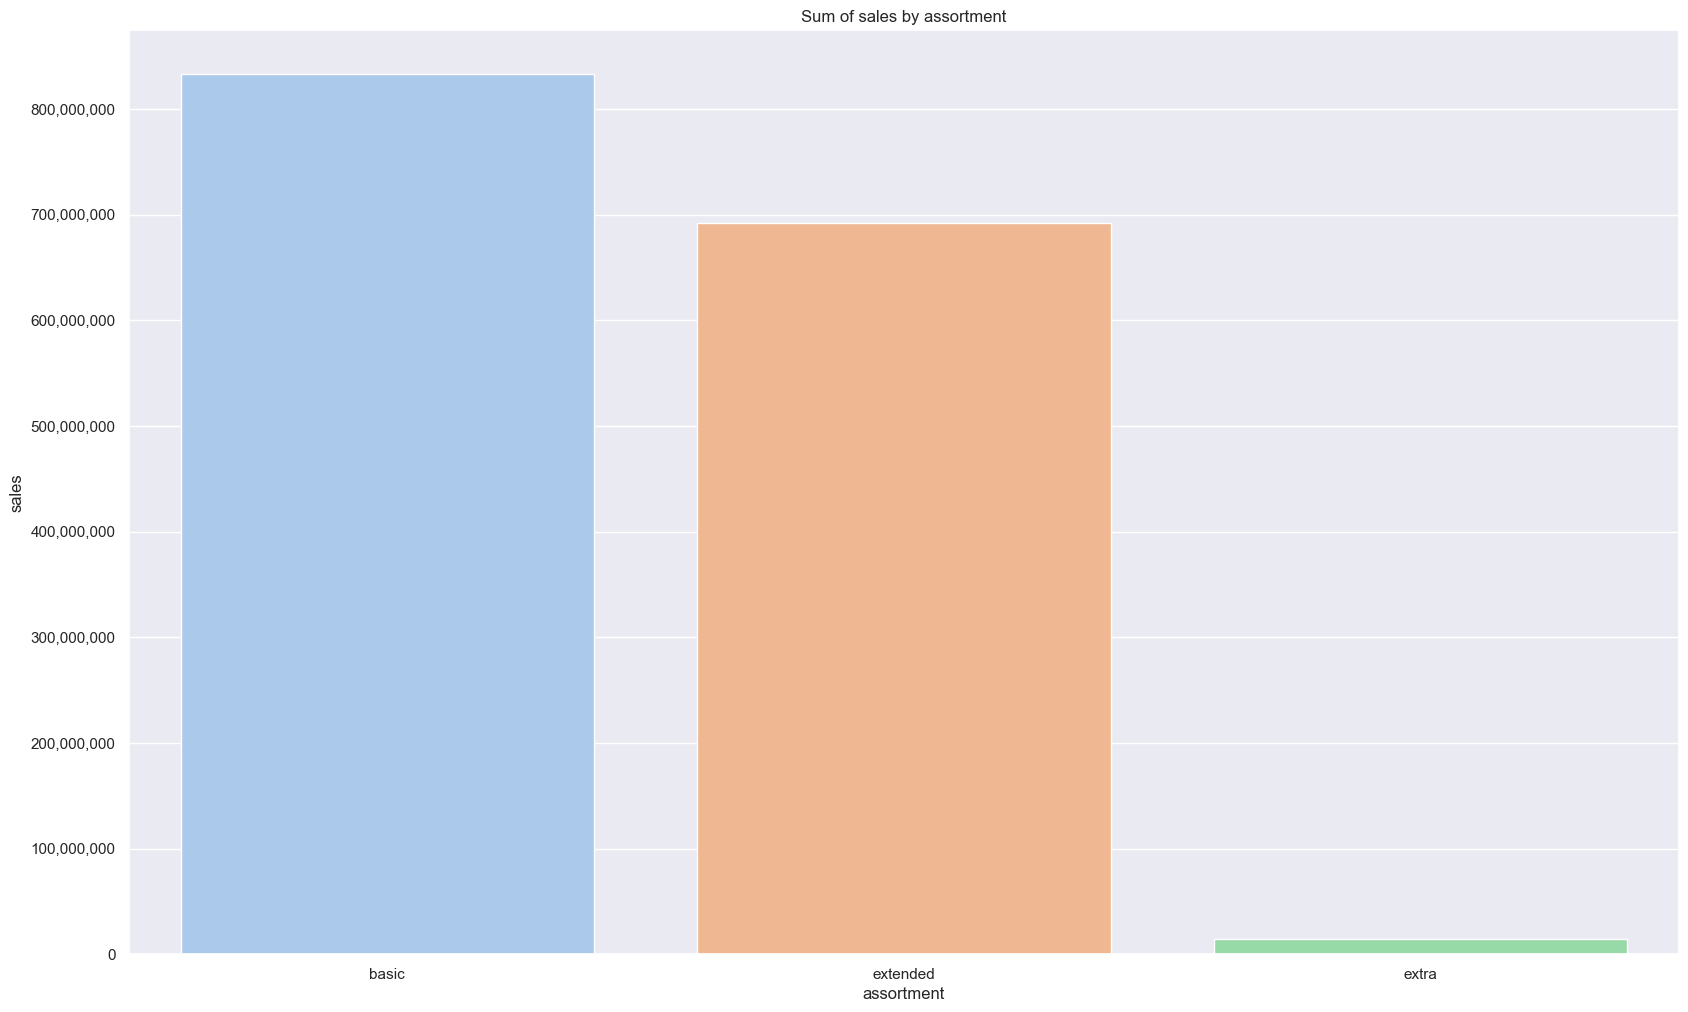

In [121]:
plt.figure(figsize=(20, 12))

# bar plot of sales by assortment
aux1 = df5[['assortment', 'sales']].groupby('assortment').sum().reset_index()

ax1 = sns.barplot(data=aux1, x='assortment', y='sales')
ax1.set_title('Sum of sales by assortment')

plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

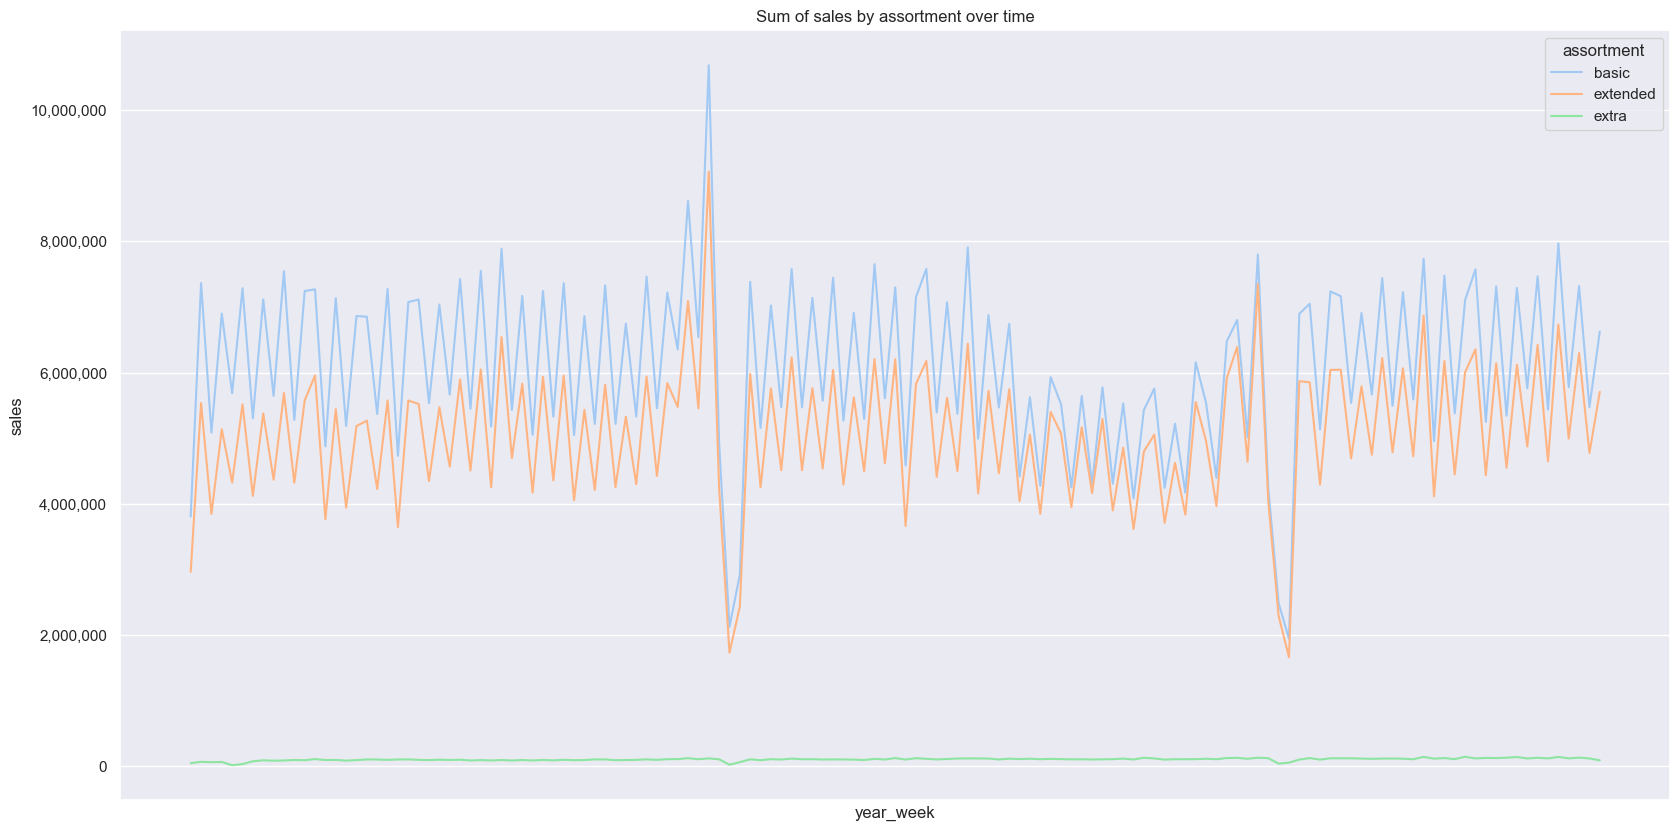

In [122]:
plt.figure(figsize=(20, 10))

# time series of sales by assortment over time
aux2 = df5[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

ax2 = sns.lineplot(data=aux2, x='year_week', y='sales', hue='assortment')
ax2.set_title('Sum of sales by assortment over time')

plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks([])
plt.show()

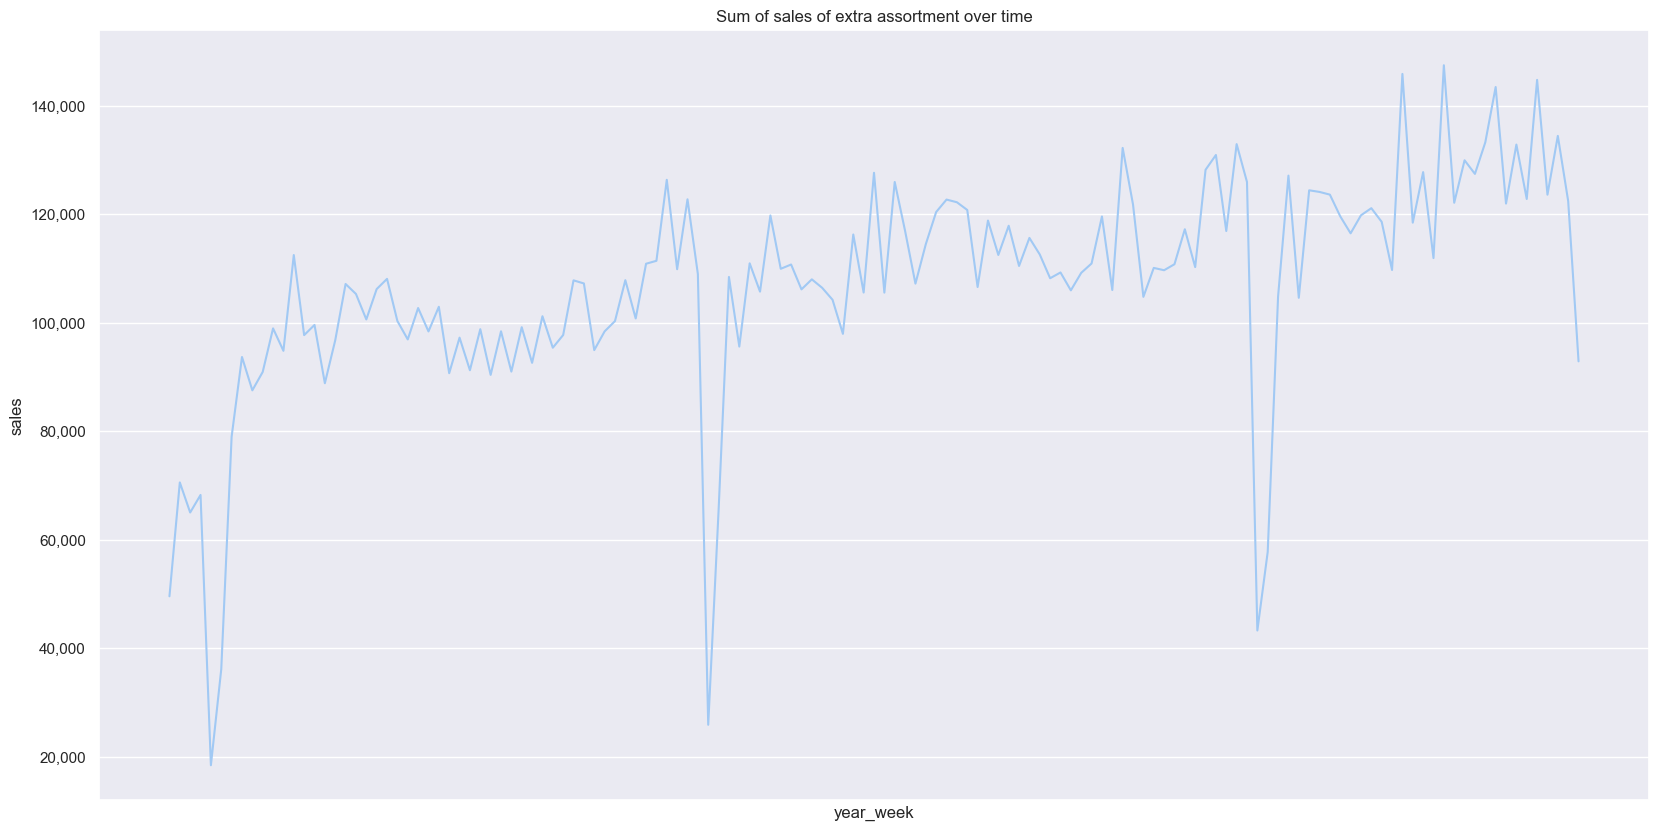

In [120]:
plt.figure(figsize=(20, 10))

# time series of extra assortment sales over time
aux3 = df5.loc[df5['assortment'] == 'extra', :]
aux3 = aux3[['year_week', 'sales']].groupby('year_week').sum().reset_index()

ax3 = sns.lineplot(data=aux3, x='year_week', y='sales')
ax3.set_title('Sum of sales of extra assortment over time')

plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks([])
plt.show()

## H2. Stores with closer competitors should sell less
(FALSE) - Stores with closer competitors sells more in volume if compared with stores with distant competitors.

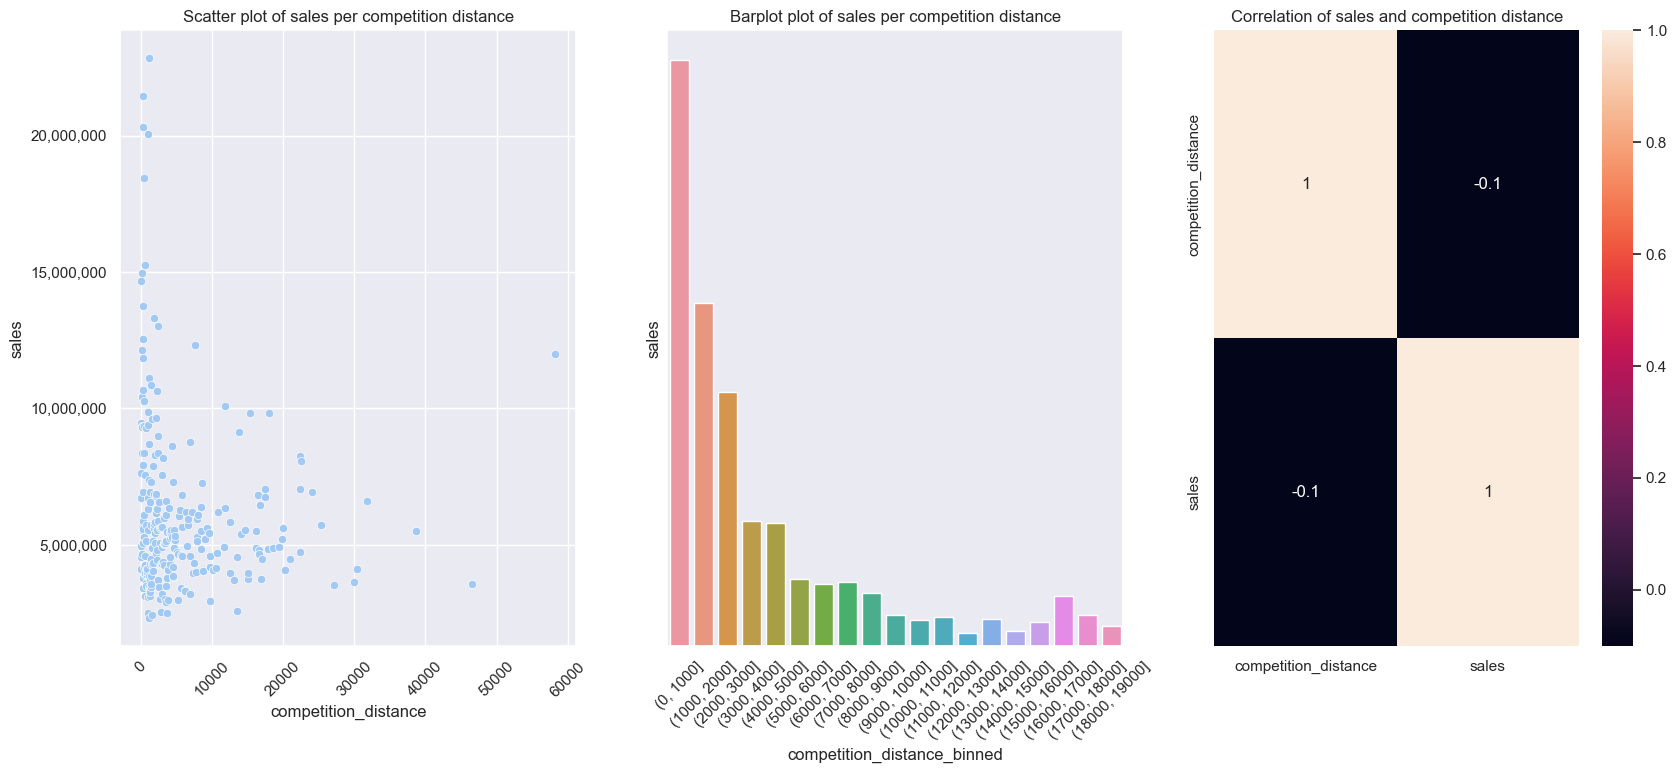

In [123]:
aux1 = df5[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
ax1 = sns.scatterplot(data=aux1, x='competition_distance', y='sales')
ax1.set_title('Scatter plot of sales per competition distance')
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], list(range(0, 20000, 1000)))
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
ax2 = sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
ax2.set_title('Barplot plot of sales per competition distance')
plt.yticks([])
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation of sales and competition distance')

plt.show()

## H3. Stores with longer-term competitors should sell more.
(FALSE) - As competition time increases, the sales volume decreases

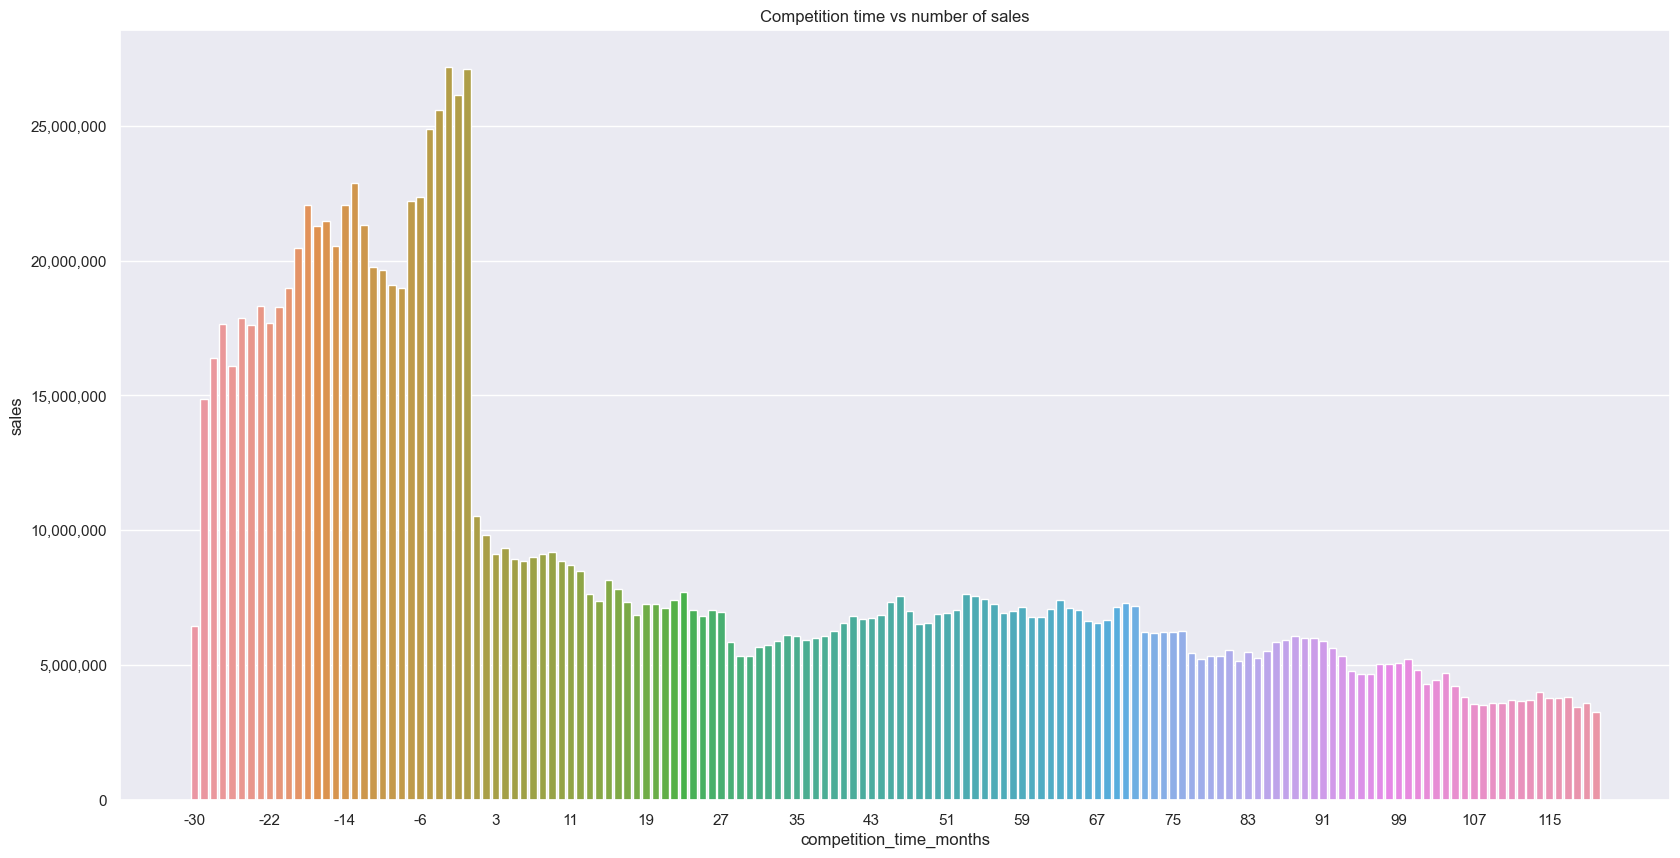

In [126]:
plt.figure(figsize=(20, 10))

min_competition = df5['competition_time_months'].min()
max_competition = 120

filter = (df5['competition_time_months'] >= min_competition) & (df5['competition_time_months'] <= max_competition) & (df5['competition_time_months'] != 0)
aux1 = df5.loc[filter, :][['competition_time_months', 'sales']].groupby('competition_time_months').sum().reset_index()
aux2 = df5[['competition_time_months', 'sales']].groupby('competition_time_months').sum().reset_index()

ax1 = sns.barplot(data=aux1, x='competition_time_months', y='sales')
ax1.set_title('Competition time vs number of sales')
ax1.locator_params(axis='x', nbins=20)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

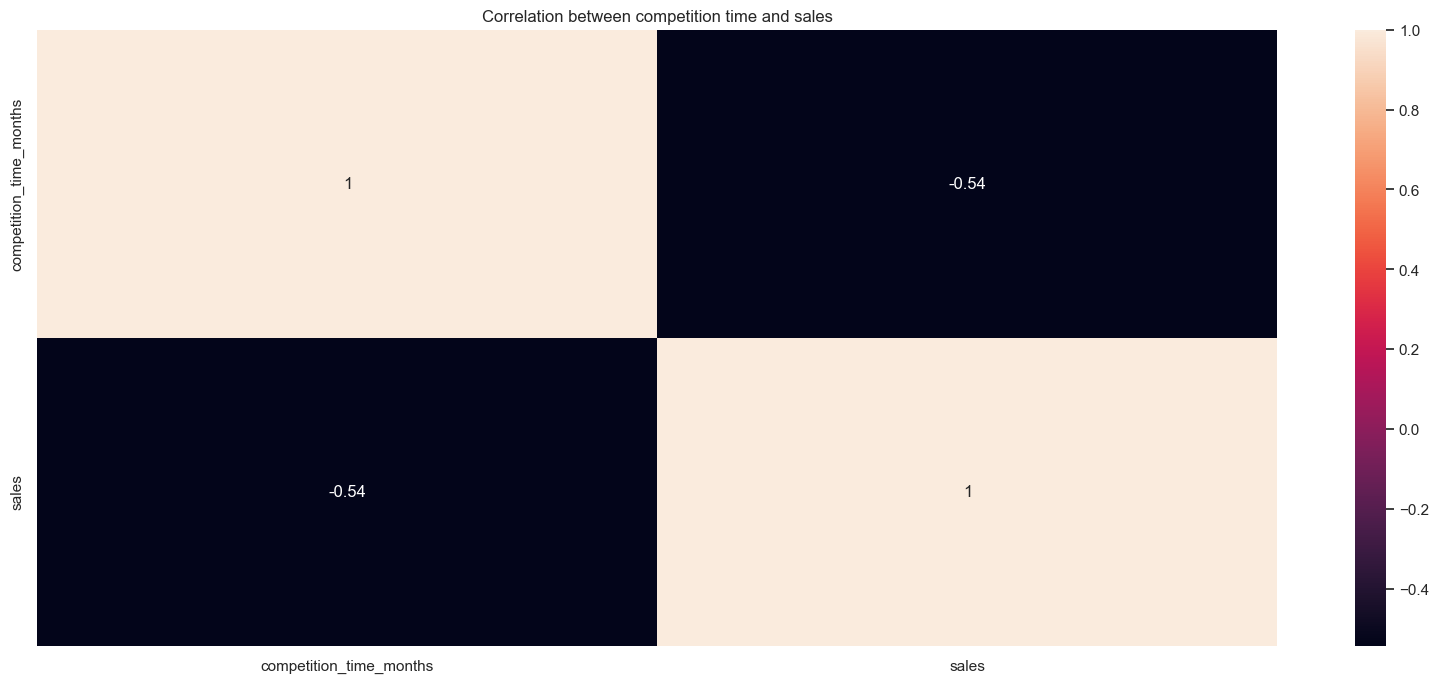

In [127]:
ax2 = sns.heatmap(aux2.corr(method='pearson'), annot=True)
ax2.set_title('Correlation between competition time and sales')
plt.show()

### H4. Stores with longer promotions should sell more
(FALSE) - Store with extended promotions tend to less over time.

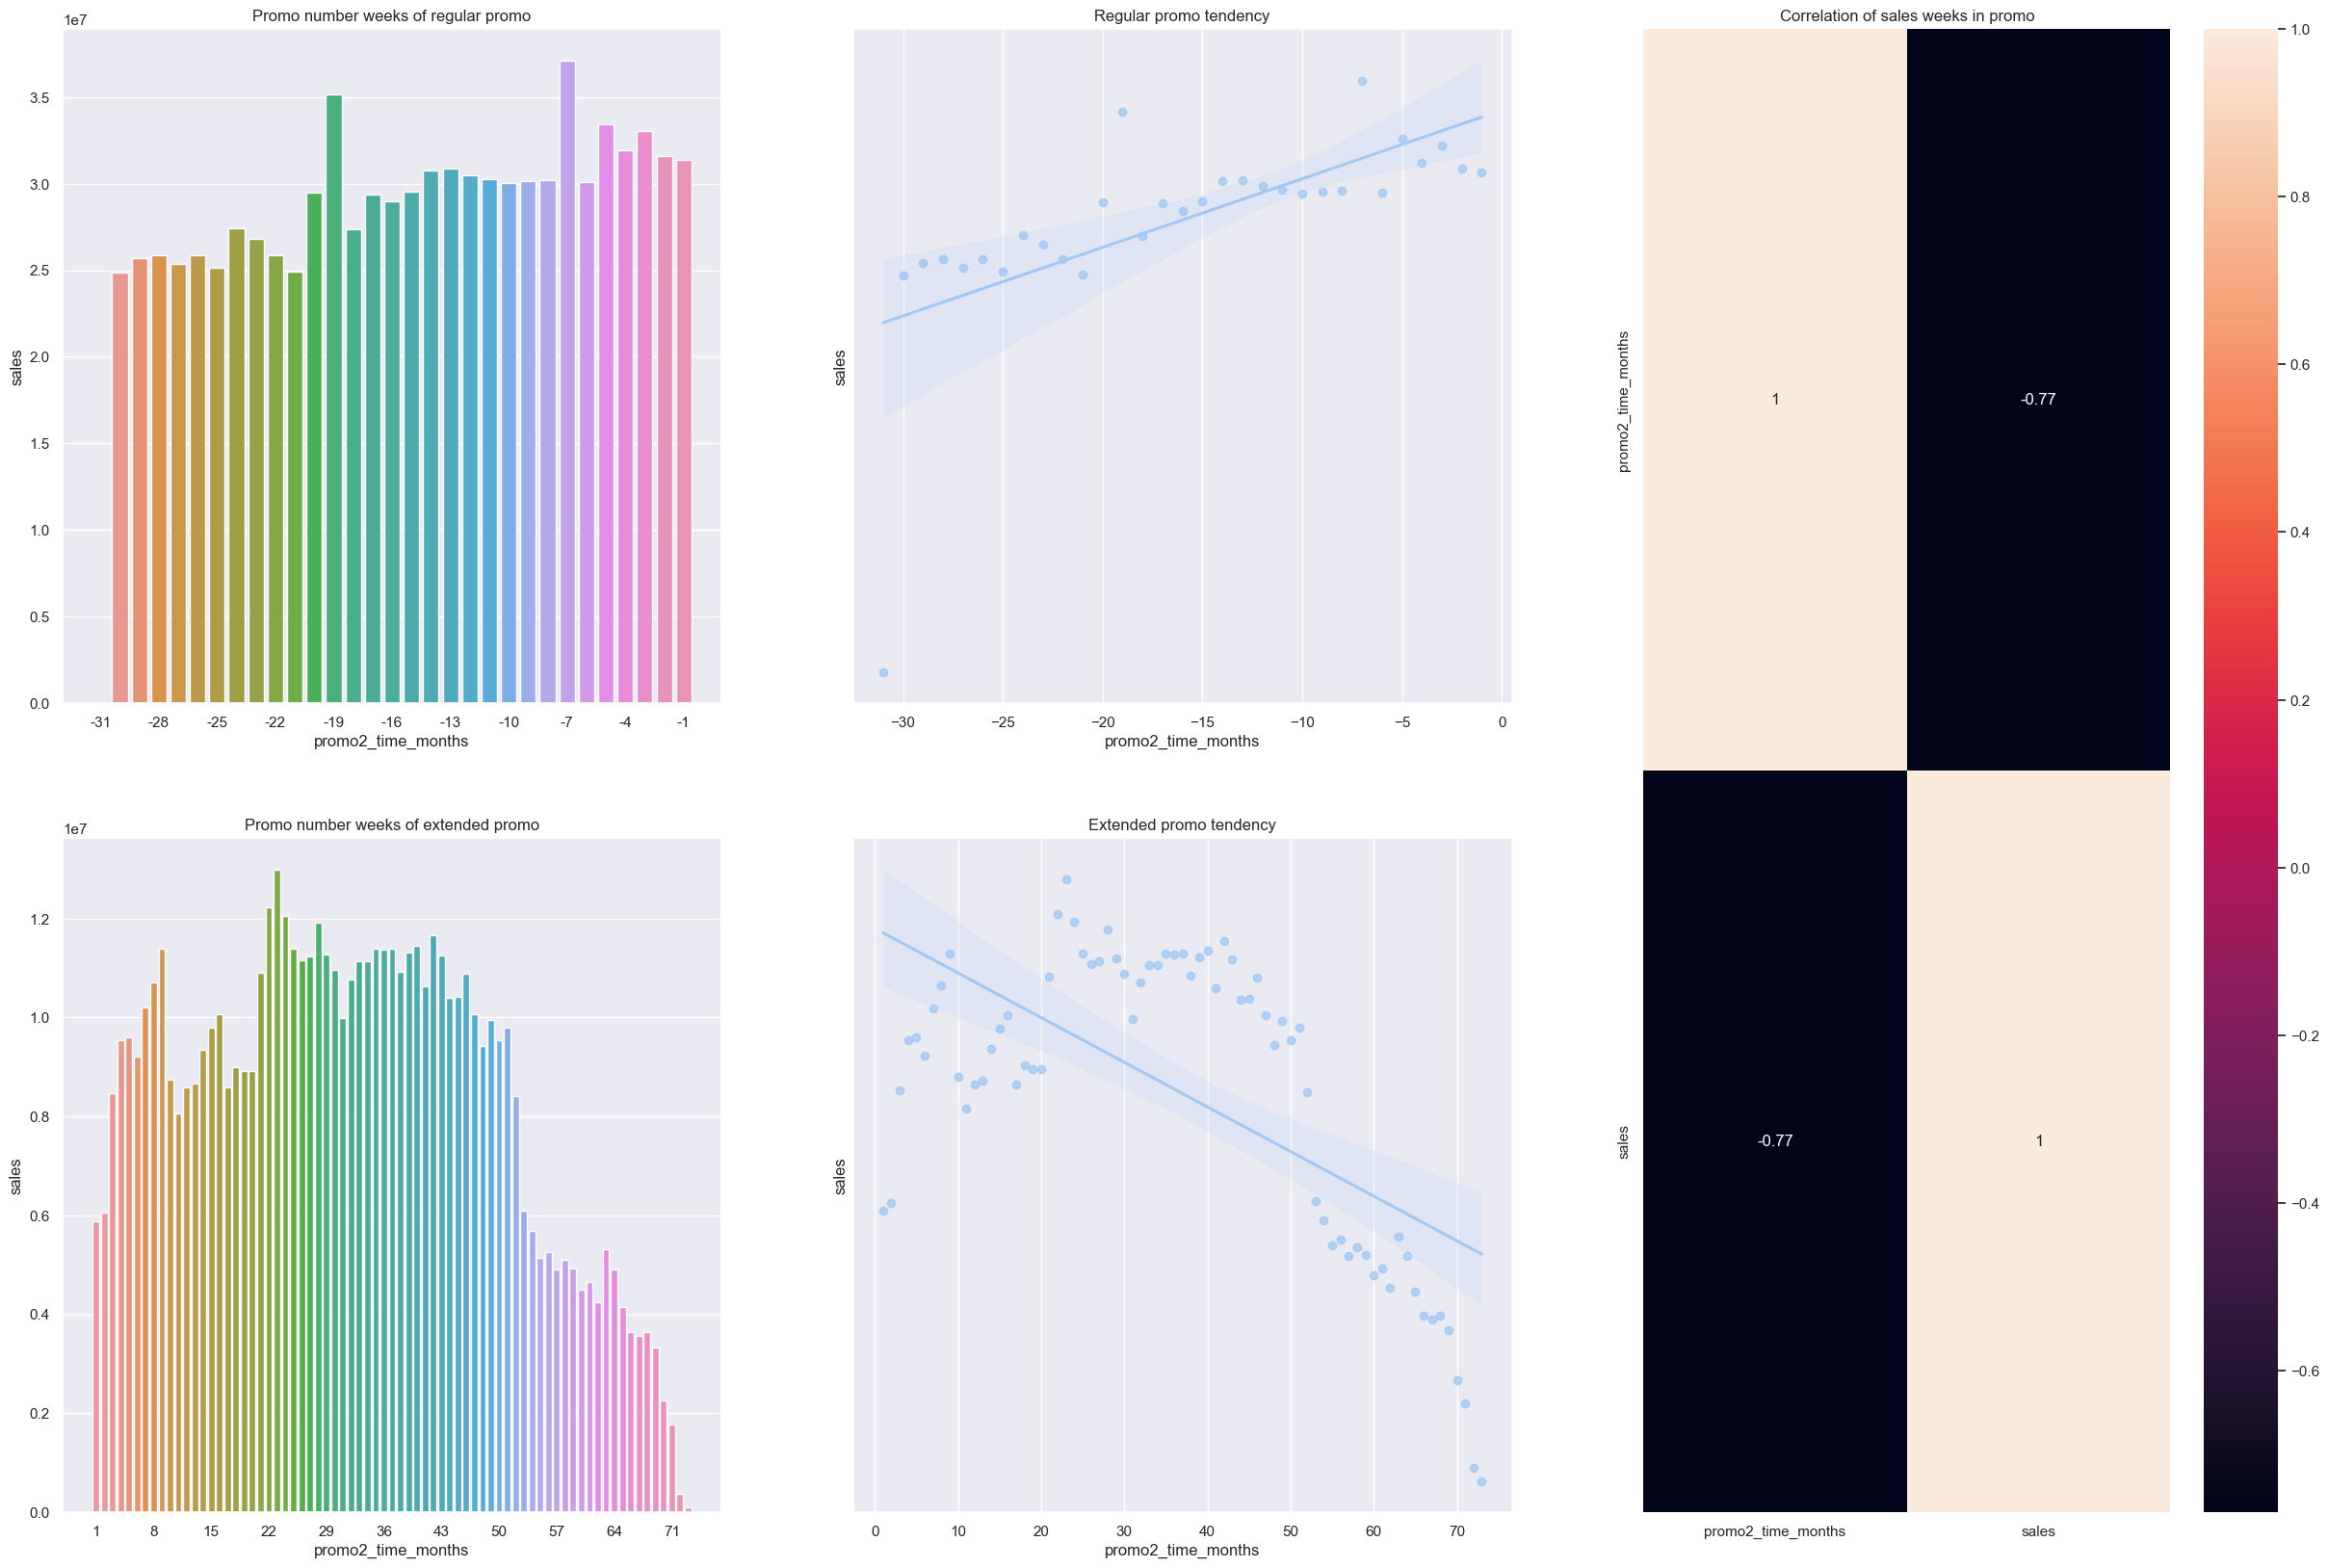

In [130]:
plt.figure(figsize=(30, 20))

aux1 = df5[['sales', 'promo2_time_months']].groupby('promo2_time_months').sum().reset_index()
aux2 = aux1[aux1['promo2_time_months'] > 0] # extended (promo)
aux3 = aux1[aux1['promo2_time_months'] < 0] # regular (promo2)

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
ax1 = sns.barplot(data=aux3, x='promo2_time_months', y='sales')
ax1.set_title('Promo number weeks of regular promo')
ax1.locator_params(axis='x', nbins=12)

plt.subplot(grid[0, 1])
ax2 = sns.regplot(data=aux3, x='promo2_time_months', y='sales')
ax2.set_title('Regular promo tendency')
plt.yticks([])

plt.subplot(grid[1, 0])
ax3 = sns.barplot(data=aux2, x='promo2_time_months', y='sales')
ax3.set_title('Promo number weeks of extended promo')
ax3.locator_params(axis='x', nbins=12)

plt.subplot(grid[1, 1])
ax4 = sns.regplot(data=aux2, x='promo2_time_months', y='sales')
ax4.set_title('Extended promo tendency')
plt.yticks([])

plt.subplot(grid[:, 2])
ax5 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax5.set_title('Correlation of sales weeks in promo')

plt.show()

## H5. Stores with more promotion days should sell more. (SKIPPED)

### H6. Stores with more consecutive promotions should sell more
(FALSE) - Stores with shorter promotions tend to sell more

In [131]:
aux1 = df5[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=False)
aux1

,promo,promo2,sales
2,1,0,431206398
0,0,0,391543926
3,1,1,383167934
1,0,1,334104579


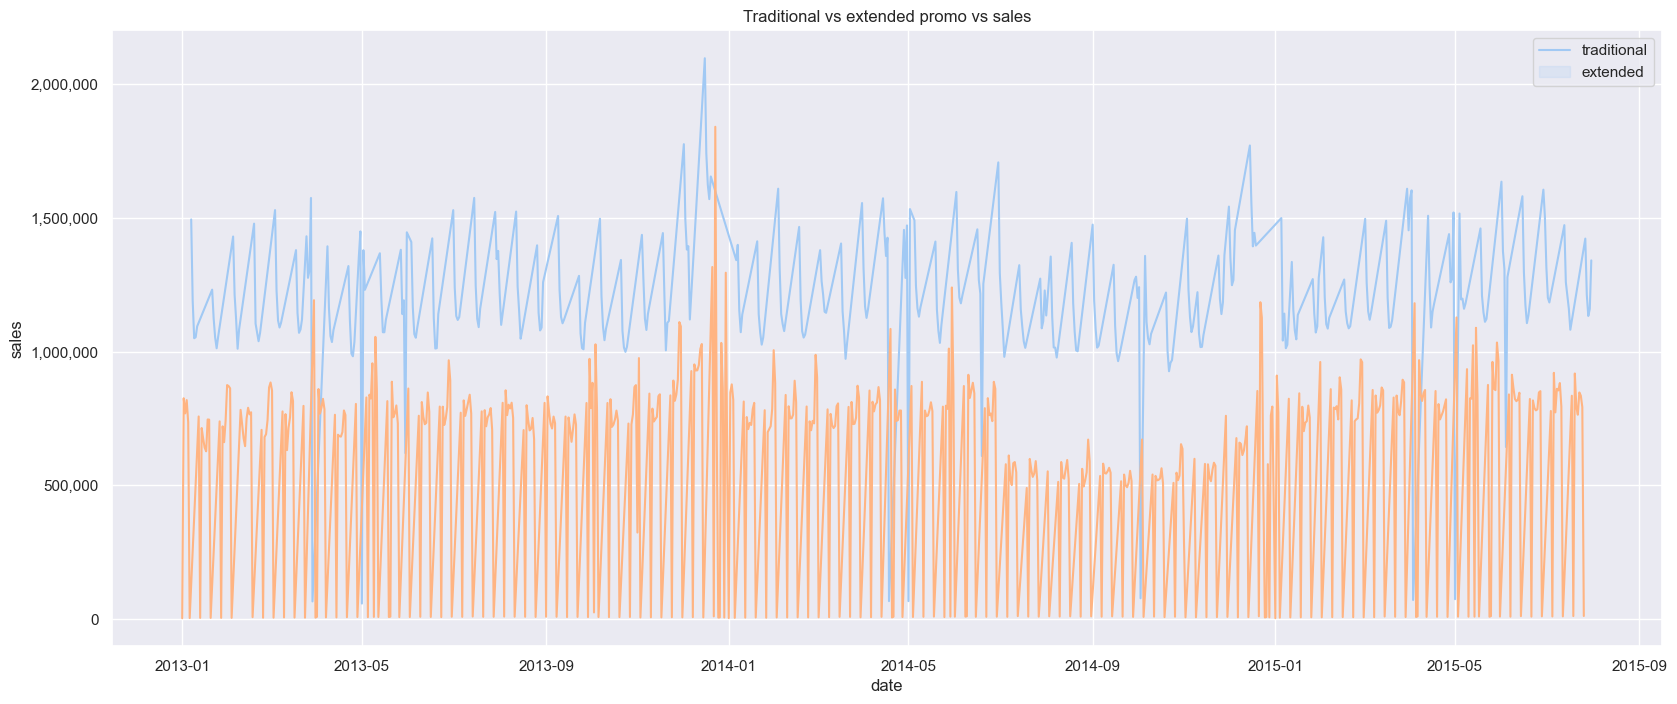

In [132]:
# traditional and extended
aux1 = df5[(df5['promo'] == 1) & (df5['promo2'] == 0)][['sales', 'date']].groupby('date').sum().reset_index()
ax = sns.lineplot(data=aux1, x='date', y='sales')

# traditional
aux2 = df5[(df5['promo'] == 0) & (df5['promo2'] == 1)][['sales', 'date']].groupby('date').sum().reset_index()
sns.lineplot(data = aux2, x='date', y='sales', ax=ax)

ax.legend(labels=['traditional', 'extended'])
ax.set_title('Traditional vs extended promo vs sales')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

## H7. Stores open during the Christmas holiday should sell more
(FALSE) - Christmas is the holiday with less sales.

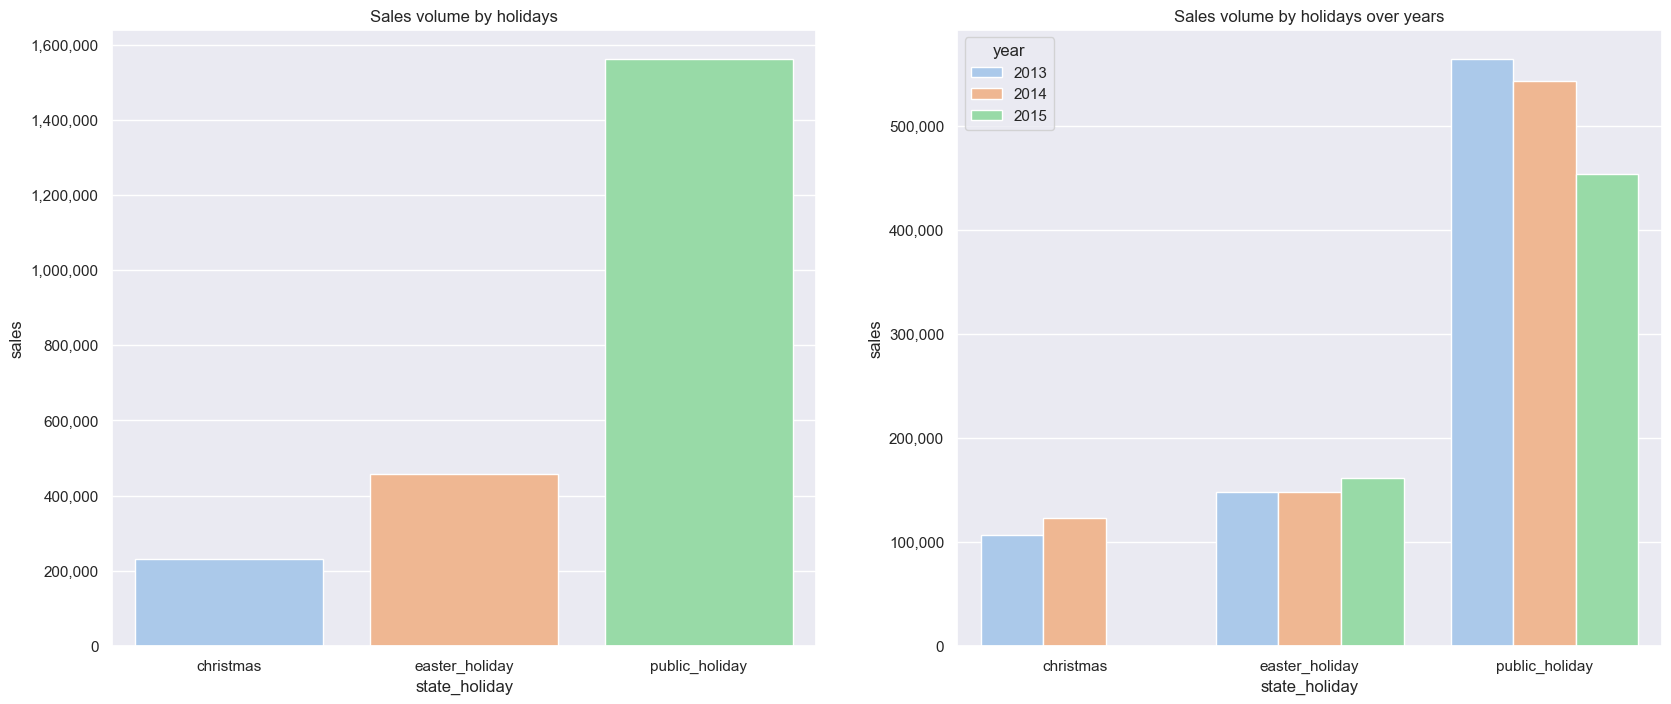

In [133]:
aux1 = df5[df5['state_holiday'] != 'no_holiday'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux2 = df5[df5['state_holiday'] != 'no_holiday'][['state_holiday', 'year', 'sales']].groupby(['state_holiday', 'year']).sum().reset_index()

plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=aux1, x='state_holiday', y='sales')
ax1.set_title('Sales volume by holidays')
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=aux2, x='state_holiday', y='sales', hue='year')
ax2.set_title('Sales volume by holidays over years')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

## H8. Stores should sell more over the years
(TRUE) - The average sales increases over years, and also, if we compare the closed period of all the three years.

We have data of three years (2013, 2014 and 2015), but 2015 we had data until jul 31th. Being so, we will analyze from two points of view. We will look at the mean sales volume, and also will look to the sales data ultil jul 31th of the other years.

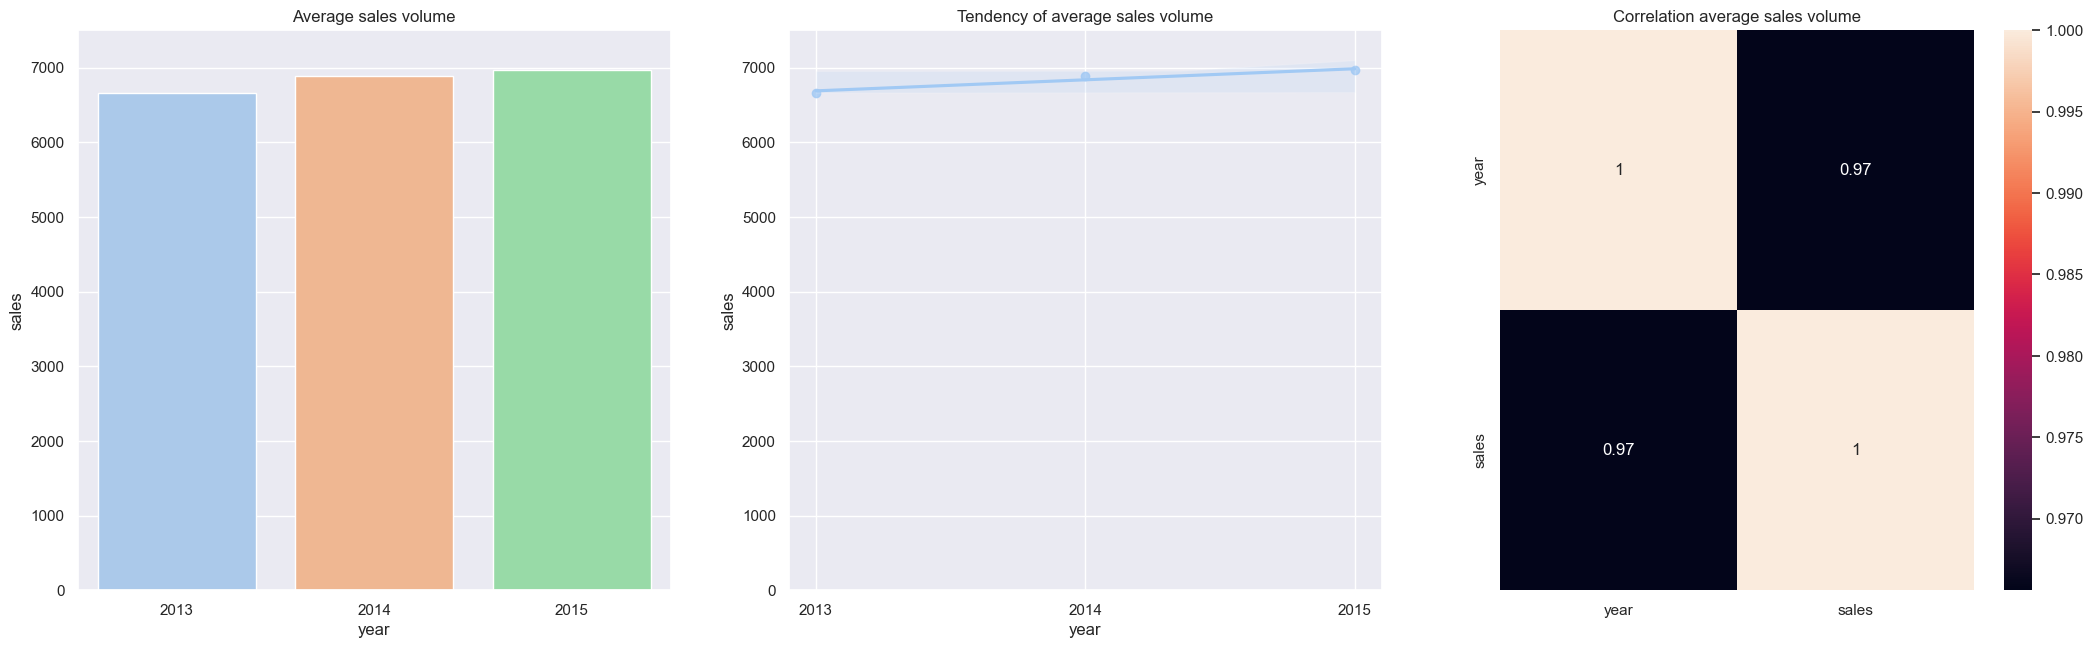

In [134]:
plt.figure(figsize=(26, 16))
aux1 = df5[['year', 'sales']].groupby('year').mean().reset_index()

plt.subplot(2, 3, 1)
ax1 = sns.barplot(data=aux1, x='year', y='sales')
ax1.set_title('Average sales volume')
plt.ylim([0, 7500])

plt.subplot(2, 3, 2)
ax2 = sns.regplot(data=aux1, x='year', y='sales')
ax2.set_title('Tendency of average sales volume')
plt.xticks([2013, 2014, 2015])
plt.ylim([0, 7500])

plt.subplot(2, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation average sales volume')

plt.show()

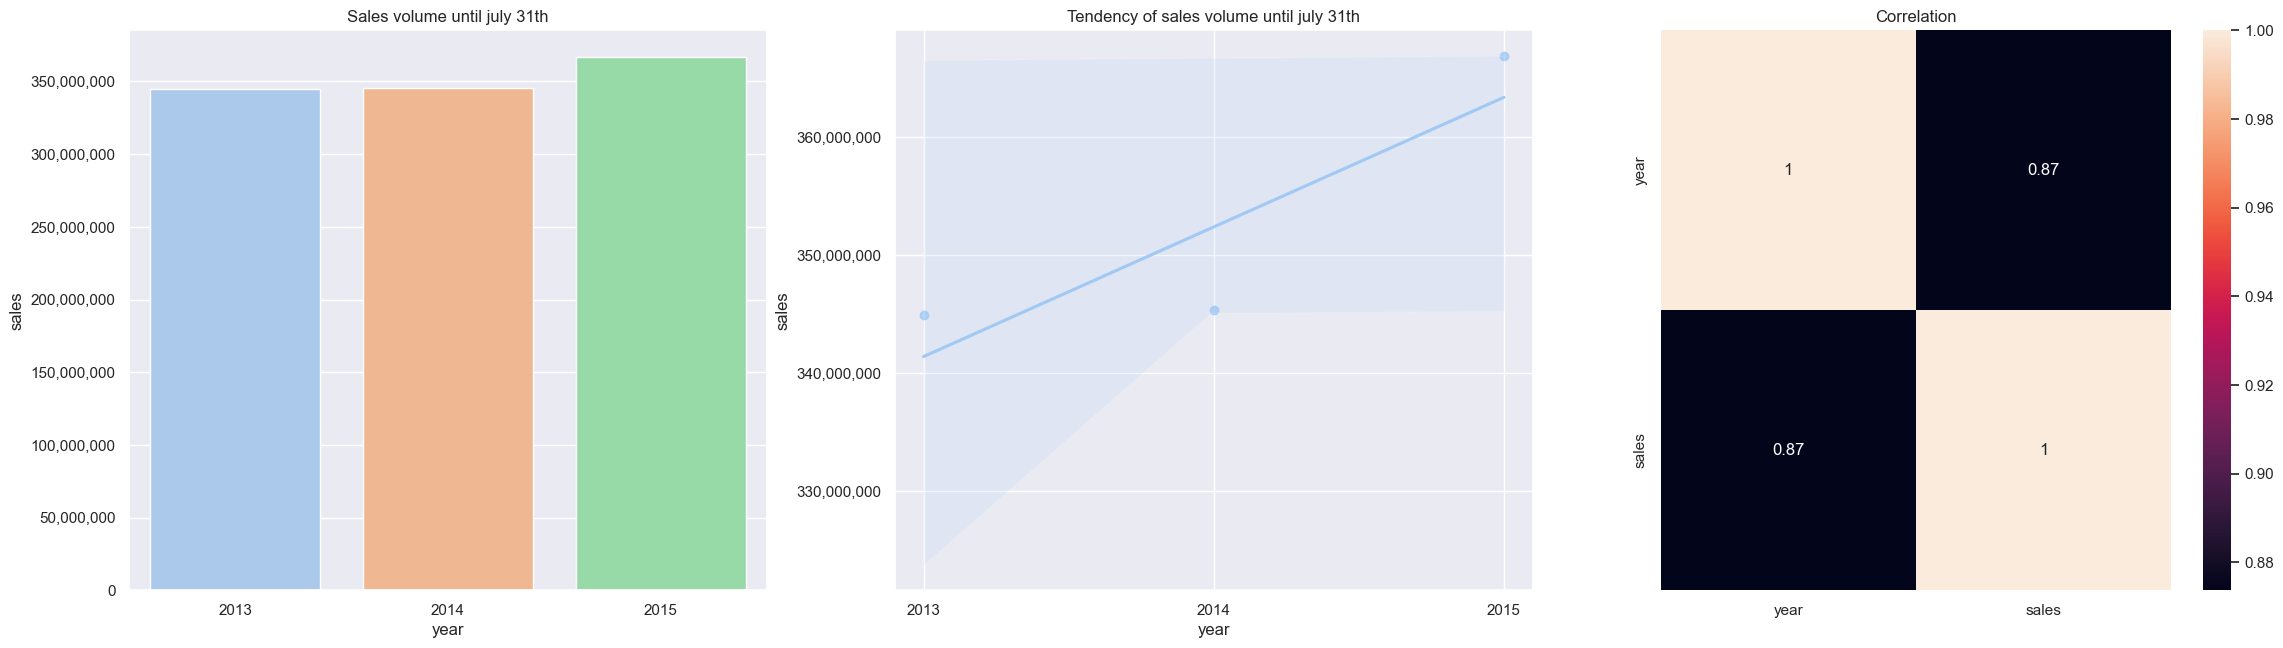

In [135]:
plt.figure(figsize=(28, 16))

f2013 = (df5['date'] >= "2013-01-01") & (df5['date'] <= "2013-07-31")
f2014 = (df5['date'] >= "2014-01-01") & (df5['date'] <= "2014-07-31")
f2015 = (df5['date'] >= "2015-01-01") & (df5['date'] <= "2015-07-31")

aux2 = df5[f2013 | f2014 | f2015][['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(2, 3, 1)
ax1 = sns.barplot(data=aux2, x='year', y='sales')
ax1.set_title('Sales volume until july 31th')
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 3, 2)
ax2 = sns.regplot(data=aux2, x='year', y='sales')
ax2.set_title('Tendency of sales volume until july 31th')
plt.xticks([2013, 2014, 2015])
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 3, 3)
ax3 = sns.heatmap(aux2.corr(method='pearson'), annot=True)
ax3.set_title('Correlation')

plt.show()

### H9. Stores should sell more in the second half of the year
(TRUE) - This is true, but only because december have a great amount of sales, which pulls the tendency up throughout the year

It is impossible to compare 2015. So, we will consider only 2013 and 2014.

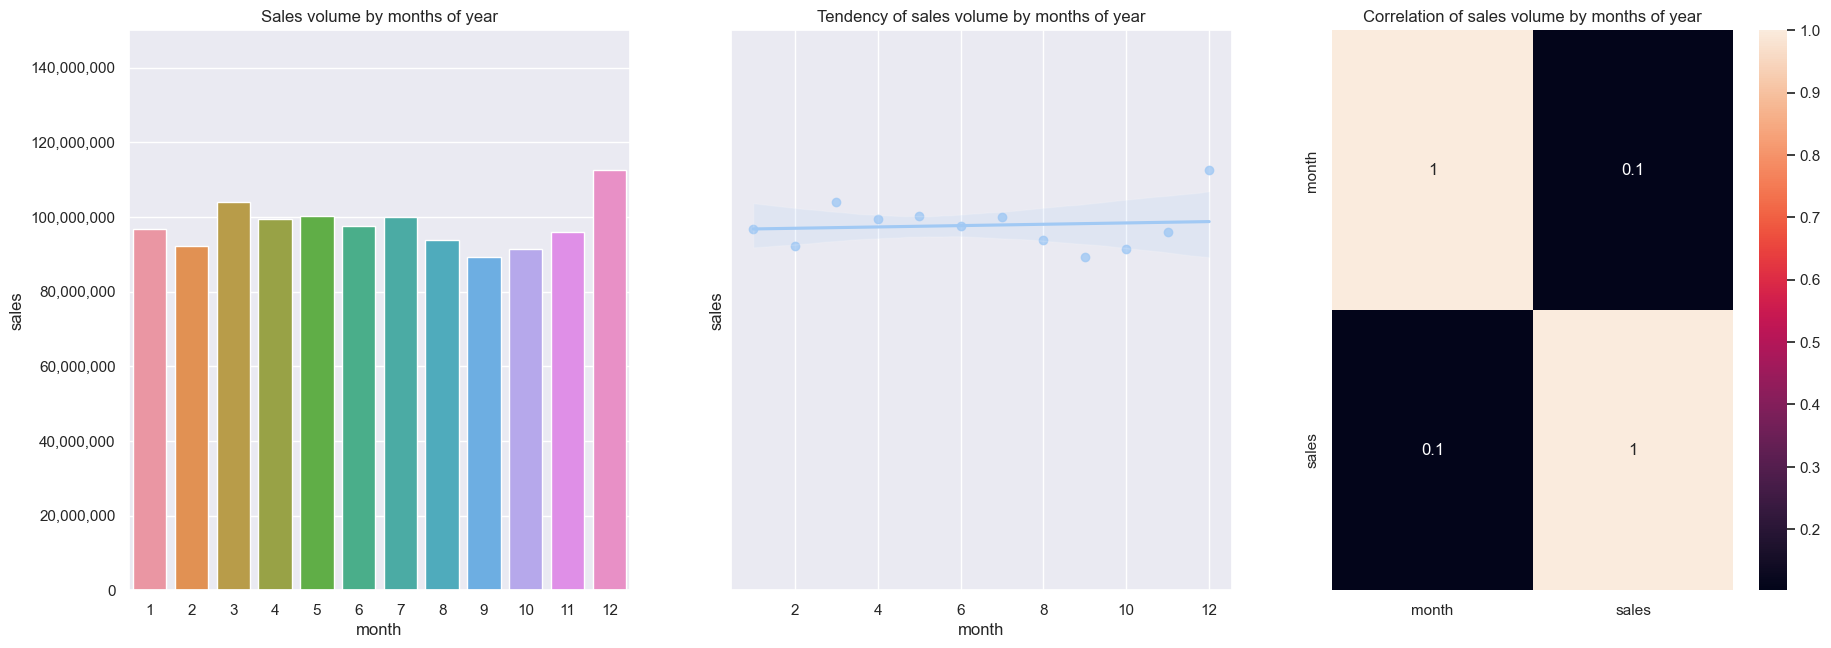

In [136]:
plt.figure(figsize=(22, 16))

aux1 = df4[df4['year'] != 2015][['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(2, 3, 1)
ax1 = sns.barplot(data=aux1, x='month', y='sales')
ax1.set_title('Sales volume by months of year') 
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 150000000])

plt.subplot(2, 3, 2)
ax2 = sns.regplot(data=aux1, x='month', y='sales')
ax2.set_title('Tendency of sales volume by months of year') 
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 150000000])
plt.yticks([])

plt.subplot(2, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation of sales volume by months of year') 

plt.show()

### H10. Stores should sell more after the 10th day of each month
(TRUE) - The majority of sales happen after the 10th day, but also, we have to consider that we have a larger window in the second half (20 days vs 10 days)

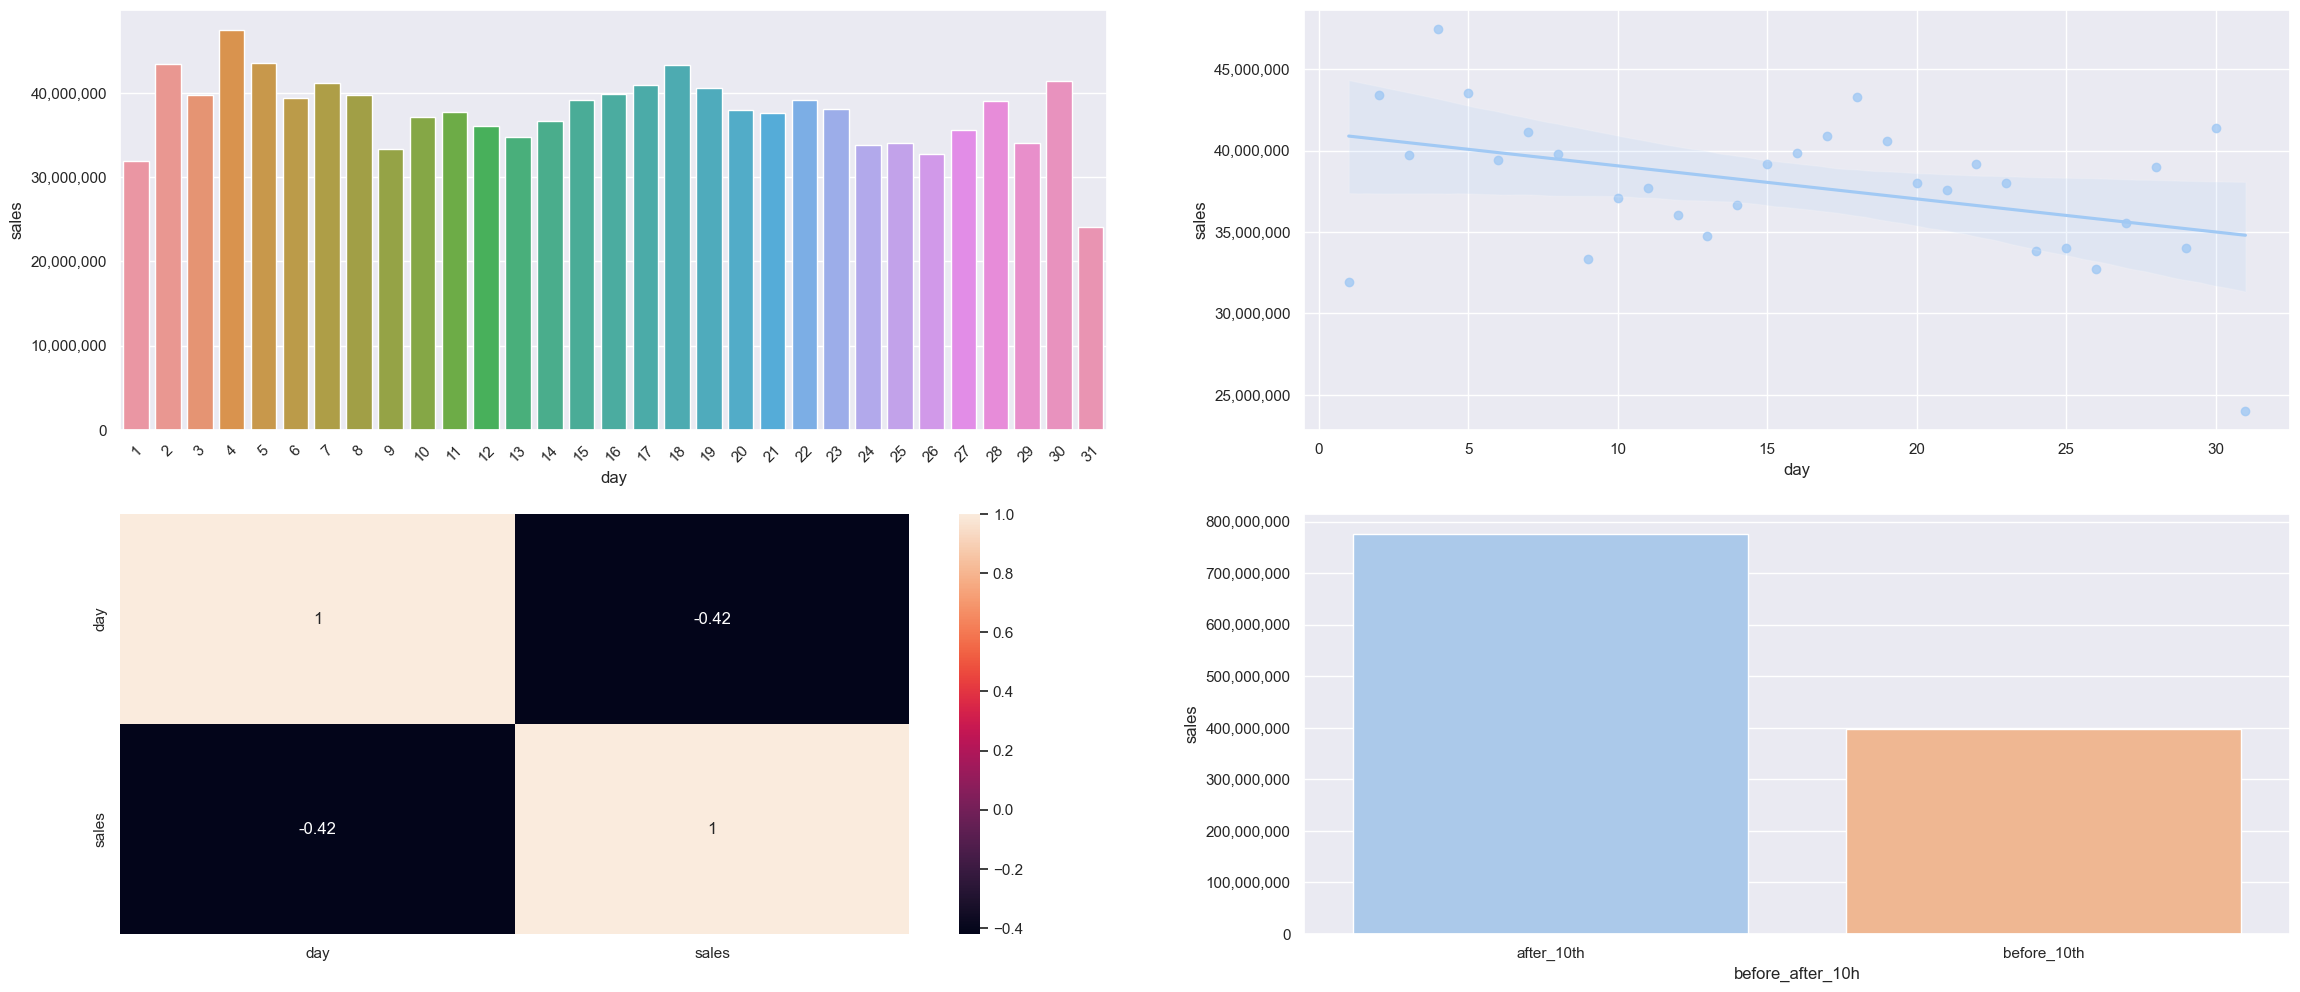

In [137]:
plt.figure(figsize=(28, 12))

aux1 = df4[df4['year'] != 2015][['day', 'sales']].groupby('day').sum().reset_index()
aux1['before_after_10h'] = aux1['day'].apply(lambda x: 'before_10th' if x <=10 else 'after_10th')
aux2 = aux1[['sales', 'before_after_10h']].groupby('before_after_10h').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(data=aux1, x='day', y='sales')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 2, 2)
sns.regplot(data=aux1, x='day', y='sales')
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2, 2, 4)
sns.barplot(data=aux2, x='before_after_10h', y='sales')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

### H11. Stores should sell less on weekends
(TRUE) - On the 6th and 7th day, the number of sales drops, especially on day 7th, which is sunday.

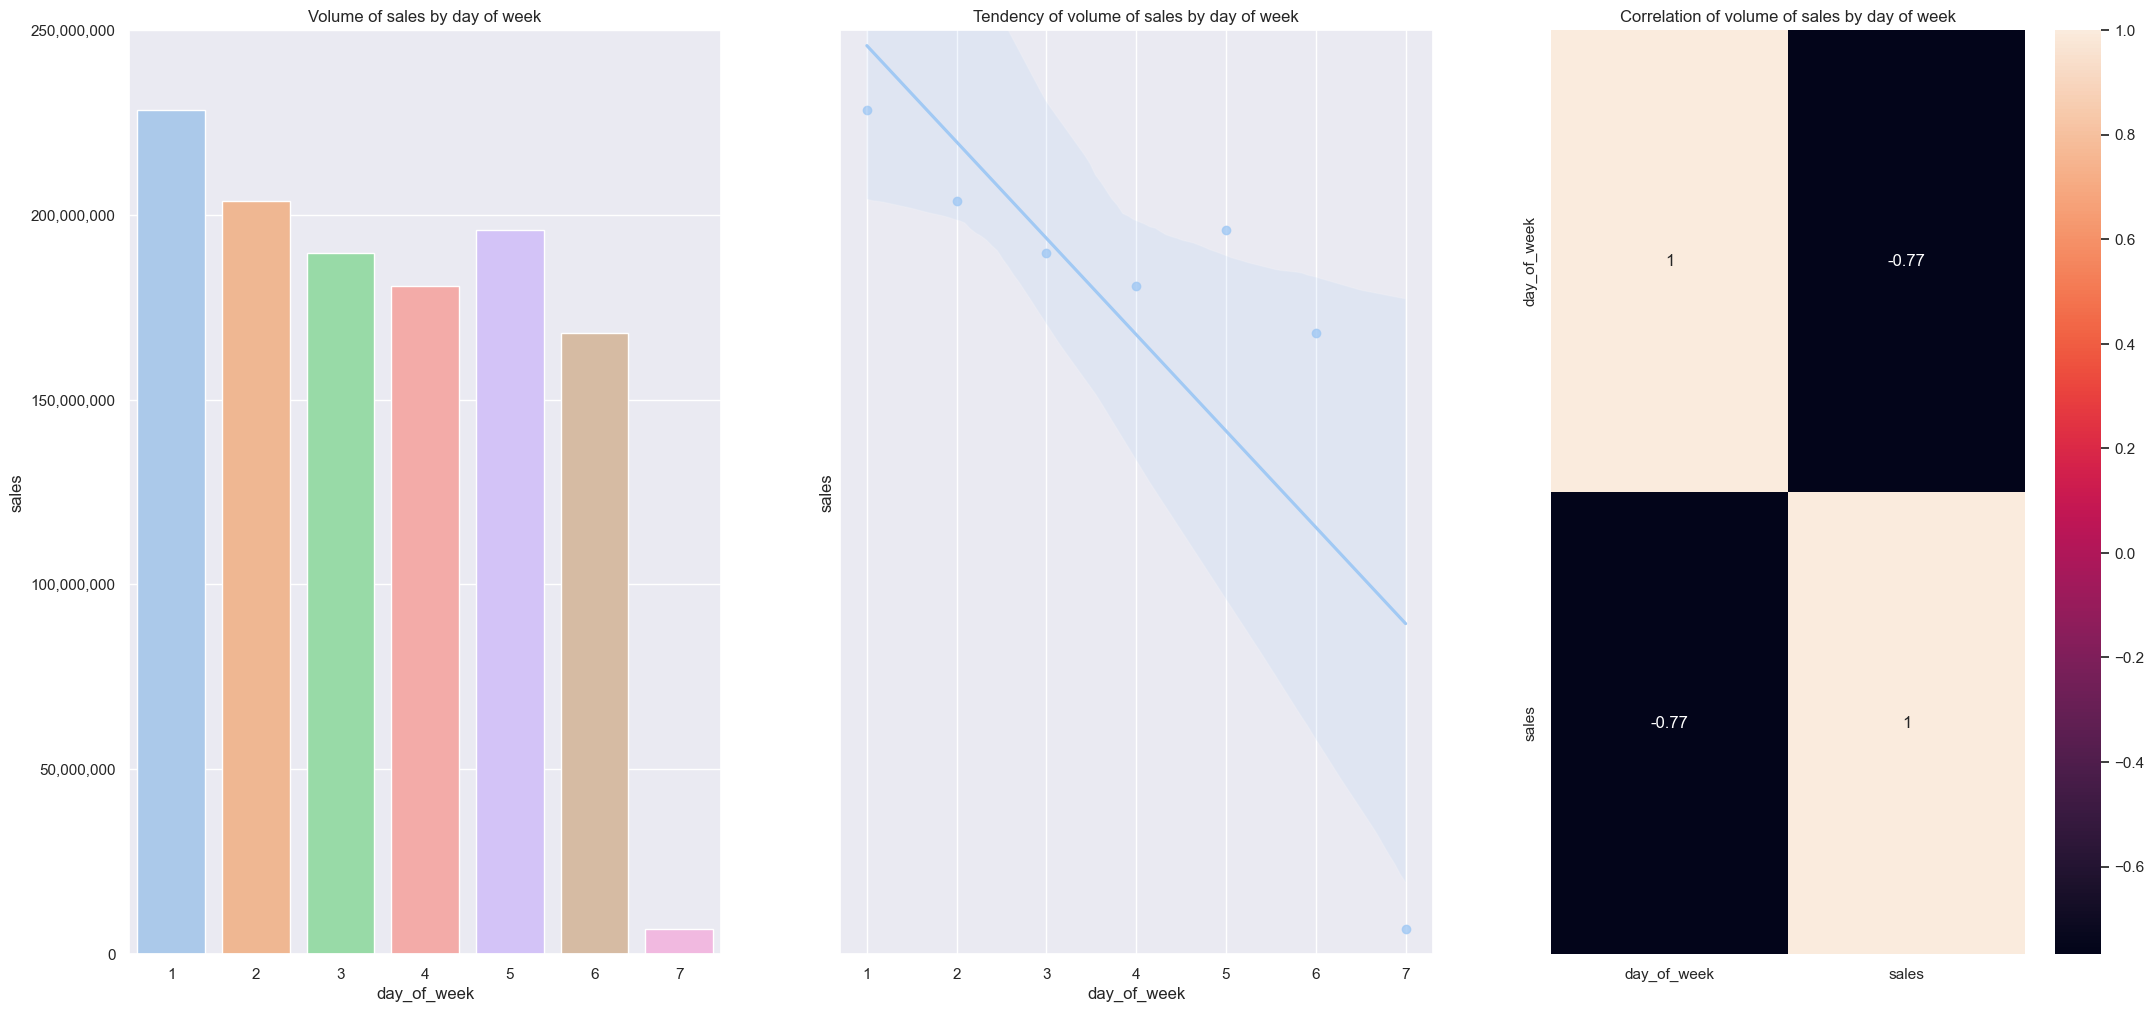

In [138]:
plt.figure(figsize=(26, 12))

aux1 = df4[df4['year'] != 2015][['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
ax1 = sns.barplot(data=aux1, x='day_of_week', y='sales')
ax1.set_title('Volume of sales by day of week')
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 250000000])

plt.subplot(1, 3, 2)
ax2 = sns.regplot(data=aux1, x='day_of_week', y='sales')
ax2.set_title('Tendency of volume of sales by day of week')
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 250000000])
plt.yticks([])

plt.subplot(1, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation of volume of sales by day of week')

plt.show()

### H12. Stores should sell less during school holidays
(TRUE) - Of course, we have to consider that the majority of time, it is not a school holiday.

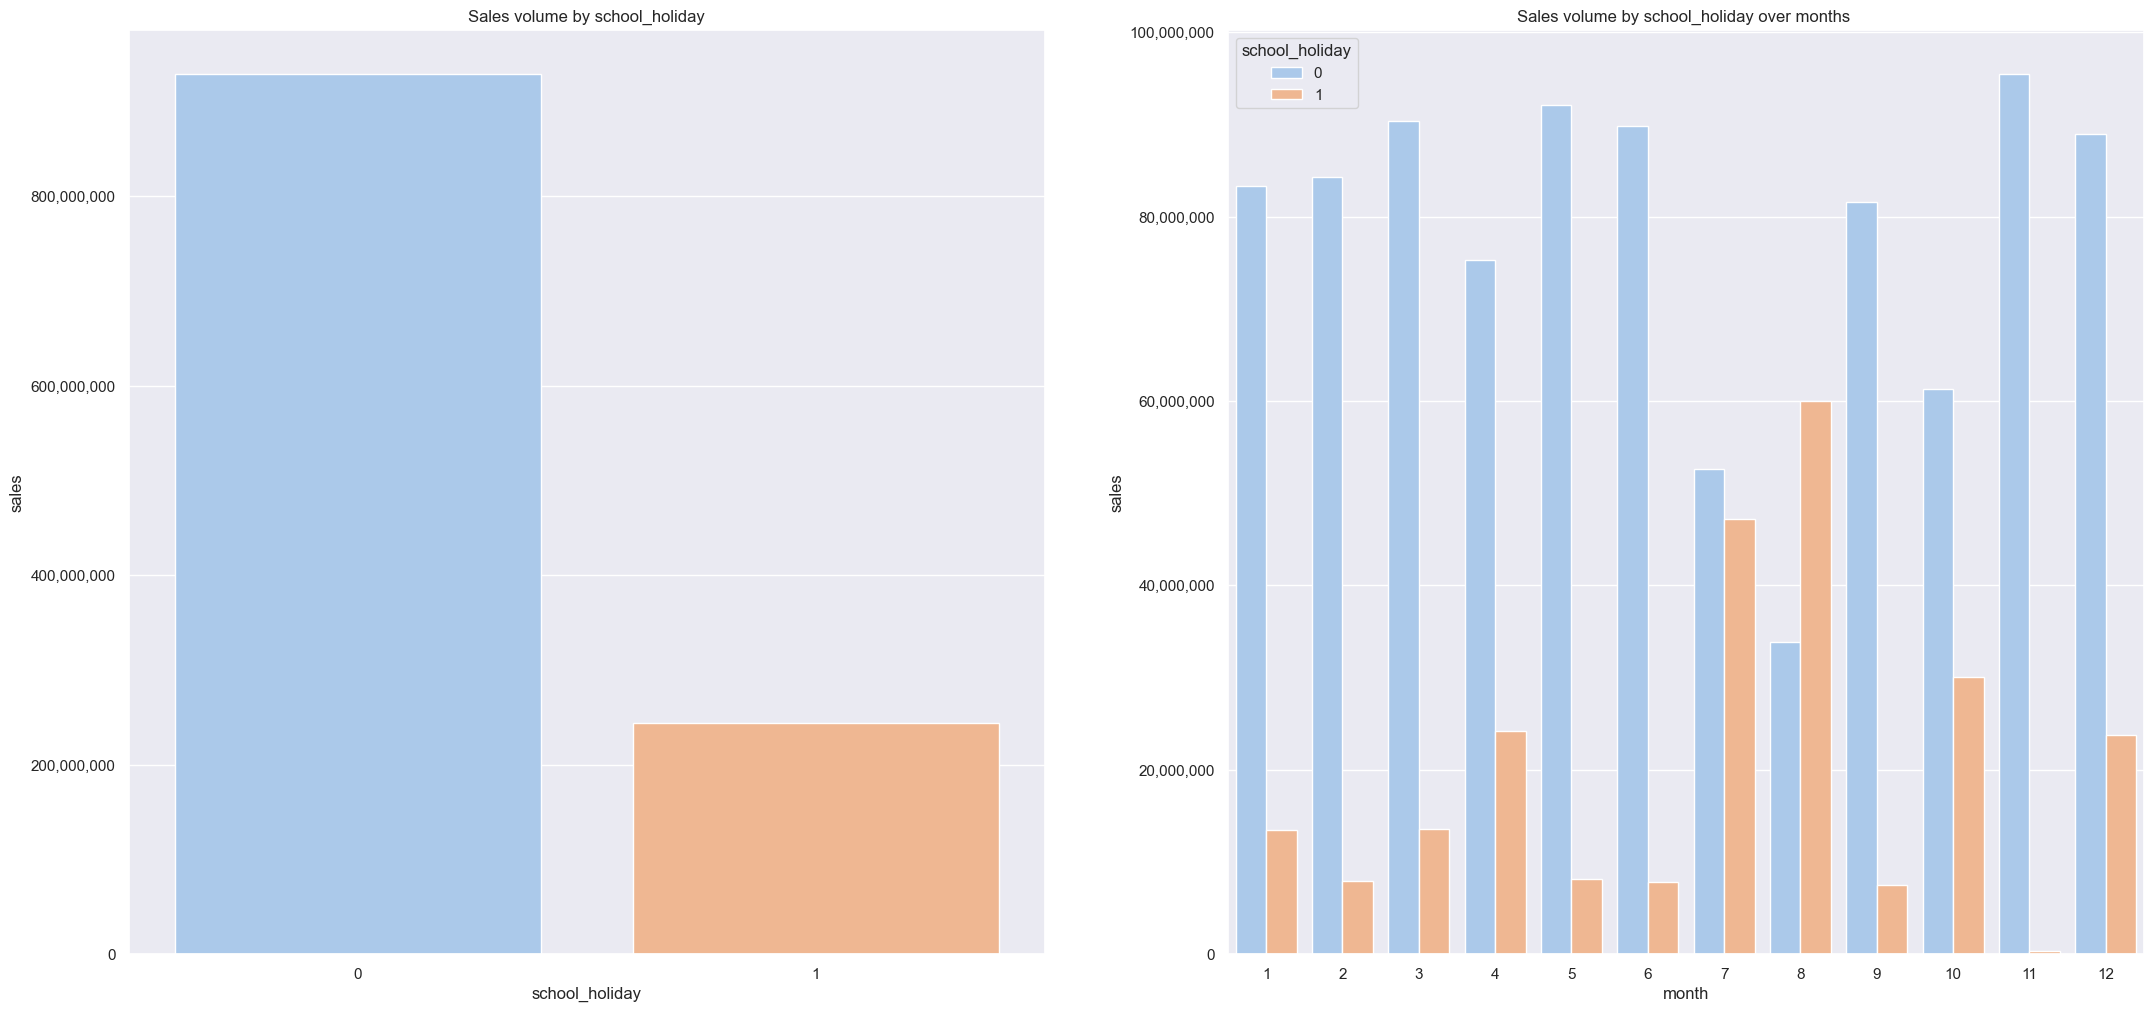

In [118]:
plt.figure(figsize=(26, 12))

aux1 = df4[df4['year'] != 2015][['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=aux1, x='school_holiday', y='sales')
ax1.set_title('Sales volume by school_holiday')
plt.gca().yaxis.set_major_formatter(formatter)

aux2 = df4[df4['year'] != 2015][['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()

plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday')
ax2.set_title('Sales volume by school_holiday over months ')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

## 4.3 MULTIVARIATE ANALYSIS

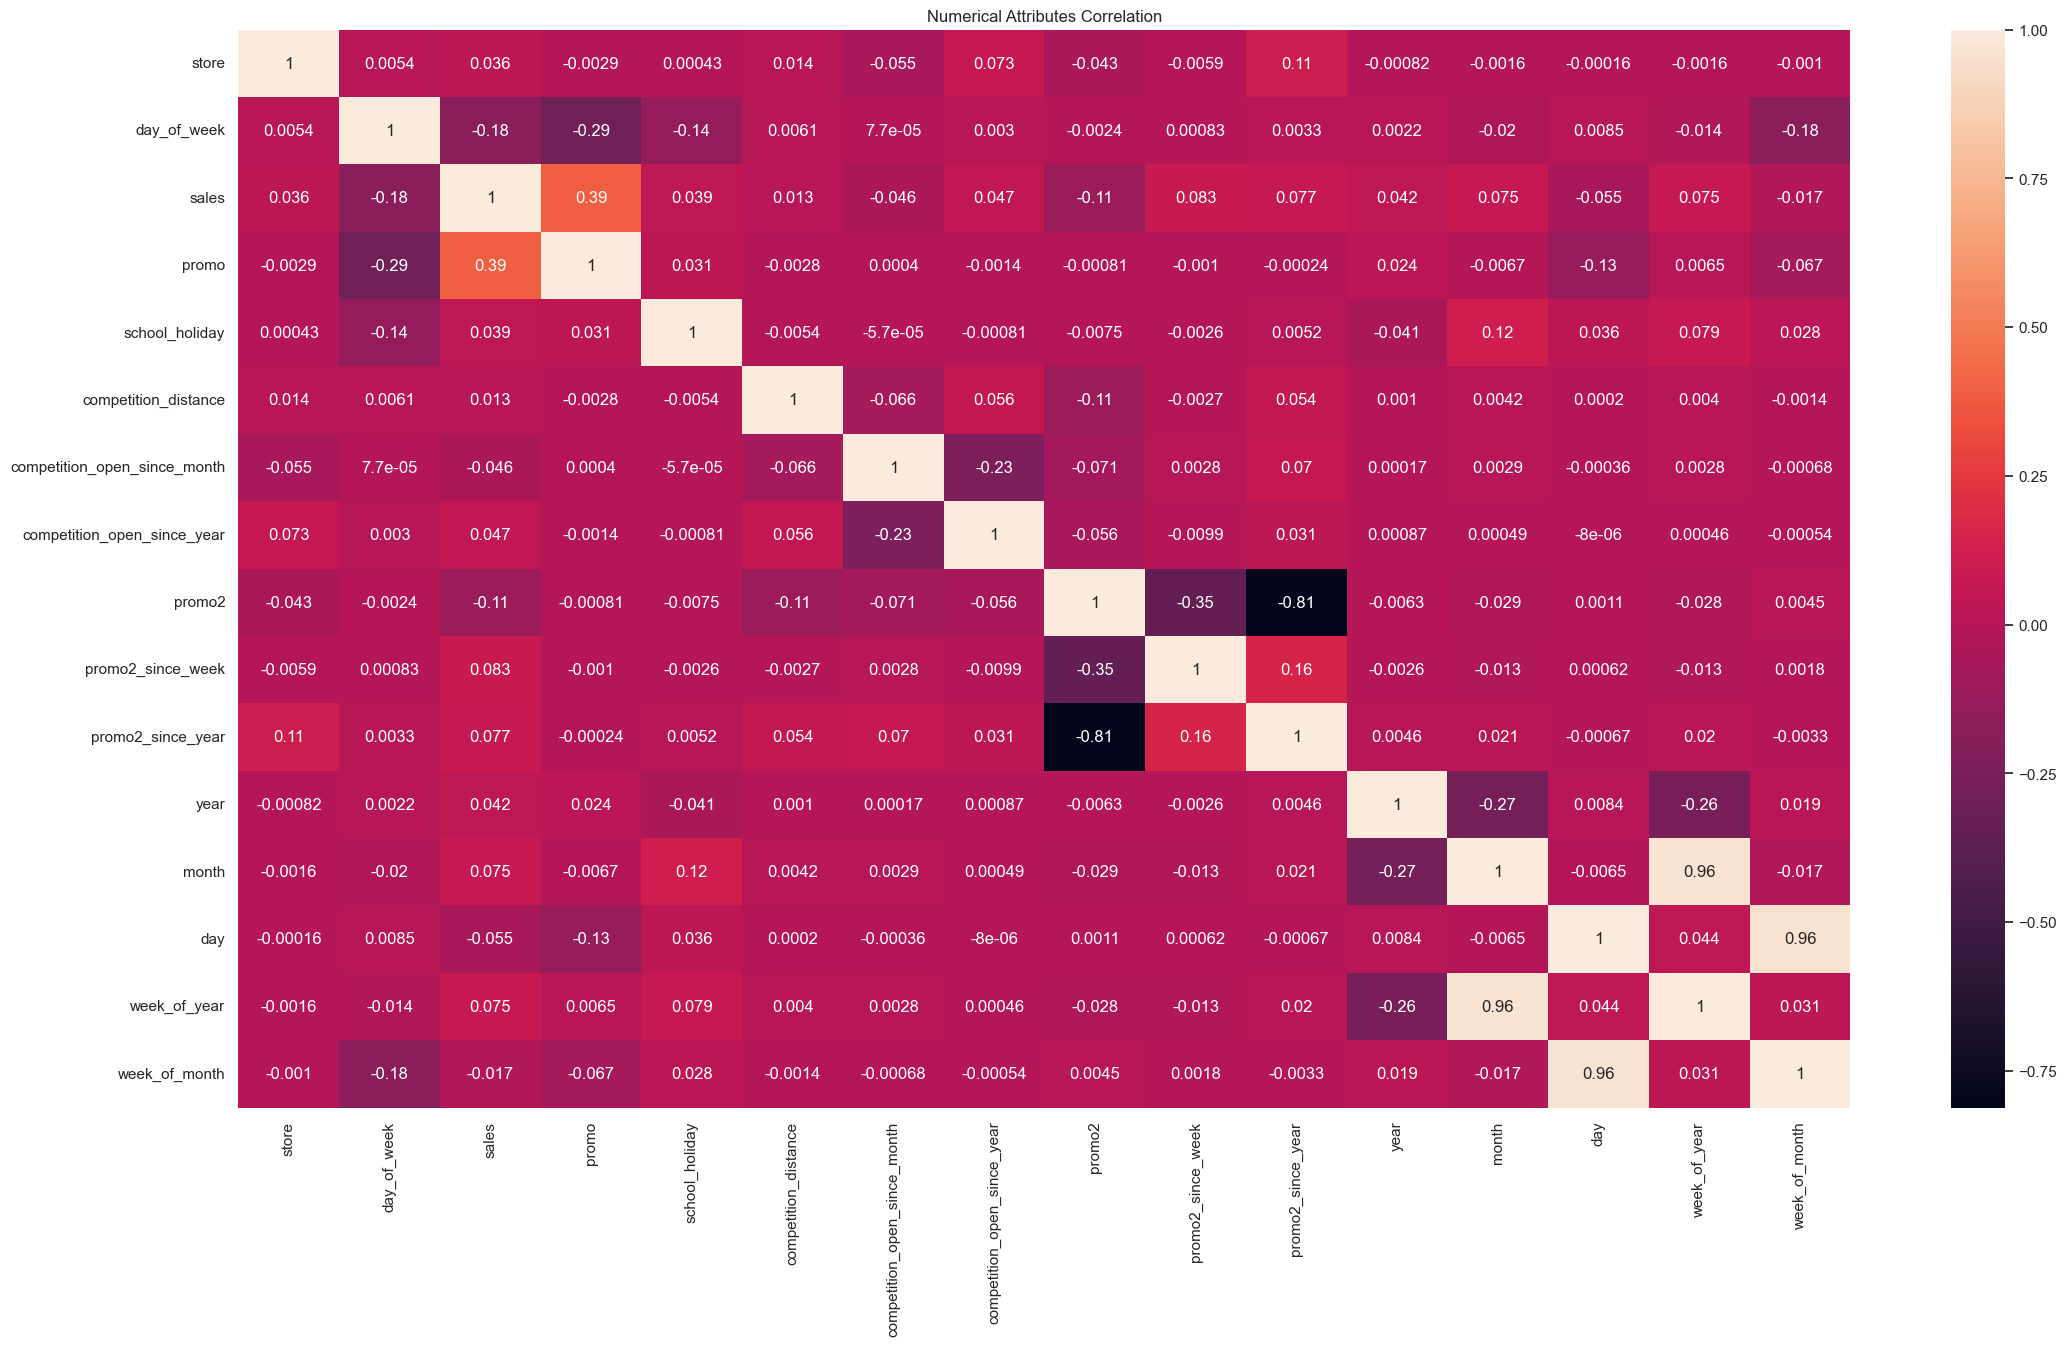

In [139]:
plt.figure(figsize=(26, 14))
correlation = num_att.corr(method='pearson')

ax1 = sns.heatmap(correlation, annot=True)
ax1.set_title('Numerical Attributes Correlation')
plt.show()

## 4.3.1 CATEGORICAL ATTRIBUTES

In [ ]:
cat_att = df4.select_dtypes(include=['object'])
cat_att.drop(columns='year_week', inplace=True)

In [140]:
# create contigency tables
holiday_vs_store = pd.crosstab(cat_att['state_holiday'], cat_att['store_type'])
holiday_vs_assortment = pd.crosstab(cat_att['state_holiday'], cat_att['assortment'])
store_vs_assortment = pd.crosstab(cat_att['store_type'], cat_att['assortment'])

In [141]:
holiday_vs_store

store_type,a,b,c,d
state_holiday,,,,
0,144622,3666,27816,88067
a,2948,62,530,1879
b,984,24,186,606
c,598,16,118,358


In [142]:
holiday_vs_assortment

assortment,a,b,c
state_holiday,,,
0,151538,1830,110803
a,3146,34,2239
b,1038,12,750
c,620,8,462


In [143]:
store_vs_assortment

assortment,a,b,c
store_type,,,
a,101456,0,47696
b,1884,1884,0
c,17530,0,11120
d,35472,0,55438


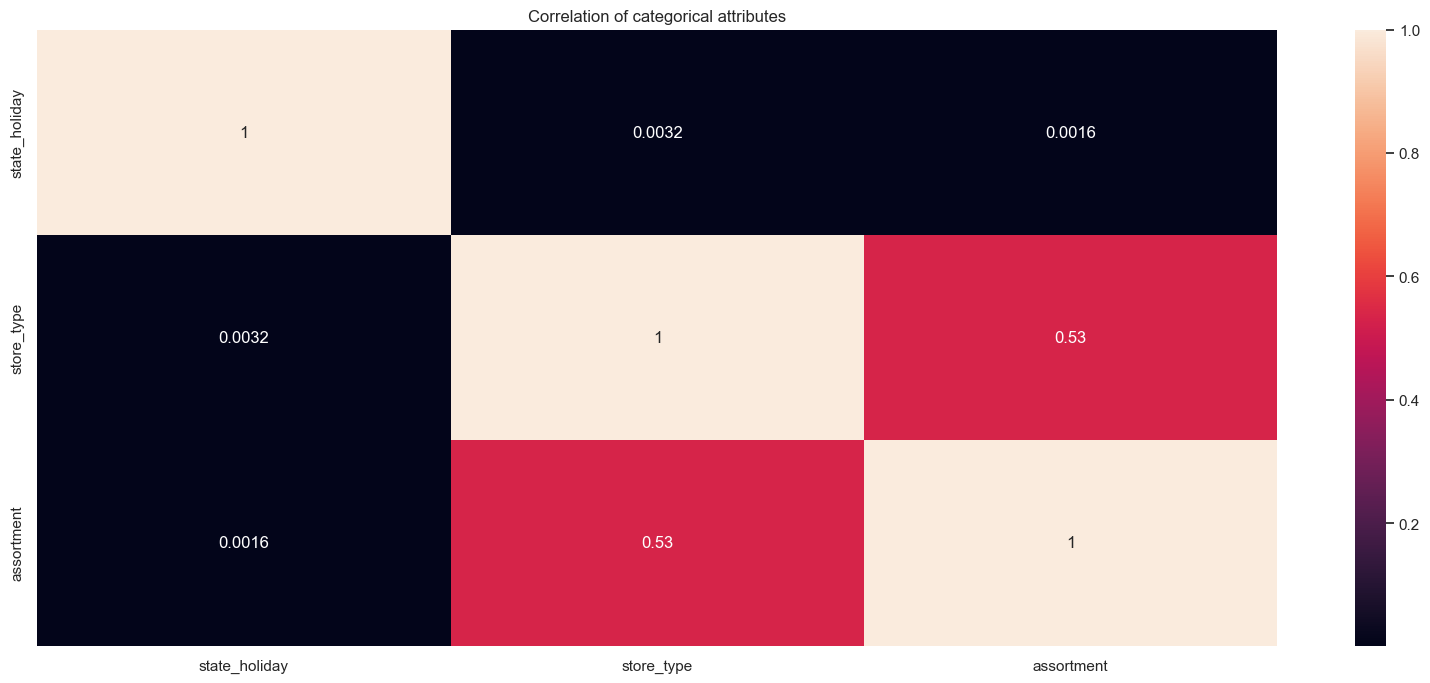

In [146]:
# creating all possible combinations
aux1 = cramers_v(cat_att, 'state_holiday', 'state_holiday')
aux2 = cramers_v(cat_att, 'state_holiday', 'store_type')
aux3 = cramers_v(cat_att, 'state_holiday', 'assortment')

aux4 = cramers_v(cat_att, 'store_type', 'state_holiday')
aux5 = cramers_v(cat_att, 'store_type', 'store_type')
aux6 = cramers_v(cat_att, 'store_type', 'assortment')

aux7 = cramers_v(cat_att, 'assortment', 'state_holiday')
aux8 = cramers_v(cat_att, 'assortment', 'store_type')
aux9 = cramers_v(cat_att, 'assortment', 'assortment')

# create dataset
aux10 = pd.DataFrame({
    'state_holiday': [aux1, aux2, aux3],
    'store_type': [aux4, aux5, aux6],
    'assortment': [aux7, aux8, aux9],
})

# rename index to the same name of columns
aux10 = aux10.set_index(aux10.columns)

# create chart
ax1 = sns.heatmap(aux10, annot=True)
ax1.set_title('Correlation of categorical attributes')
plt.show()

# 6. DATA PREPARATION

In [147]:
df6 = df5.copy()

## 6.1 NORMALIZATION

In [160]:
df6['sales'] =  df6['sales'].apply(lambda x: (x - mean)/std)
df6['sales']

0        -0.533650
1        -0.257963
2         0.516436
3         2.471710
4        -0.685432
            ...   
226020   -0.783867
226021   -0.892627
226022    0.012904
226023    3.597859
226024   -1.277418
Name: sales, Length: 226025, dtype: float64

## 6.2 RESCALING

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

In [161]:
df6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day',
       'week_of_year', 'week_of_month', 'year_week', 'competition_since_date',
       'competition_time_months', 'competition_time_weeks', 'promo2_since',
       'promo2_time_months', 'promo2_time_weeks'],
      dtype='object')

## 6.3 TRANSFORMATION

In [159]:
# operação inversa do z score
#normalized.apply(lambda x: x * std + mean)